# Assignment No. 2
<br>
<h4>Data Mining and Machine Learning  Semester 1</h4>

<span style='font-size:11px; line-height:1.5;'>Fatima Mohamed [H00335257]<br></span>
<span style='font-size:11px; line-height:1.5;'>Stephy Savier [H00211075]<br></span>
<span style='font-size:11px; line-height:1.5;'>Muhammad Nauman Qureshi [H00348353]<br></span>
<span style='font-size:11px; line-height:1.5;'>Mohammed Farhan Majid [H00364845]<br></span>

# Environment Setup

In [1]:
import sys
import sklearn
assert sklearn.__version__ >= "0.20"
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import shutil
import cv2
import time
import pydot
import pydotplus
import matplotlib
import warnings
import seaborn as sns
import datetime as dt
import shap


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
   
from IPython.core.display import display, HTML
display(HTML("""<style>
div#notebook p, div#notebook{line-height: 100%;}
.CodeMirror, .CodeMirror pre, .CodeMirror-dialog, .CodeMirror-dialog .CodeMirror-search-field, .terminal-app .terminal {font-size: 100%;}
.container { width:100% !important; } 
.rendered_html pre, .rendered_html table { font-size:9px !important; }, 
.rendered_html h1 { font-size: 36px !important; font-weight:normal !important; line-height:99%; margin:0px !important; }
.rendered_html h2 { font-size: 32px !important; font-weight:normal !important; line-height:99%; margin:0px !important; }
.rendered_html h3 { font-size: 24px !important; font-weight:normal !important; line-height:99%; margin:0px !important; }
.rendered_html h4 { font-size: 18px !important; font-weight:normal !important; line-height:99%; margin:0px !important; }
.rendered_html h5 { font-size: 16px !important; font-weight:normal !important; line-height:99%; margin:0px !important; font-weight:normal; color:#555;}
.rendered_html h6 { font-size: 14px !important; font-weight:normal !important; line-height:99%; margin:0px !important; font-weight:normal; color:#555;}
.rendered_html hr {  margin: 0 !important; border: 0; border-top: 1px solid #555;
                </style>"""))
pd.options.display.max_columns = 100
pd.options.display.max_rows=500

# Functions

In [2]:
def f_start():
    return time.time()
def f_end(_start_time):
    print("Processed in %s seconds." % round(time.time() - _start_time, 2))

In [3]:
def f_HighlightMax(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [4]:
def f_PlotMultipleImages(instances, images_per_row=10, size = 48, **options):
    images_per_row = min (len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros ((size, size * n_empty)))
    for row in range (n_rows):
        rimages = images [row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image)
    plt.axis("off")

In [5]:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [6]:
def f_createModel():
    os.environ['PYTHONHASHSEED']=str(RANDOM_STATE)
    np.random.seed=RANDOM_STATE
    tf.keras.seed=RANDOM_STATE
    _model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax'), #No of Classes
    ])
    return _model

In [7]:
def f_ModelGridSearch(optimizer='adam', init='glorot_uniform'):
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, kernel_initializer=init, activation='relu'),
    tf.keras.layers.Dense(10,  kernel_initializer=init, activation='softmax'), #No of Classes
])
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model 

In [8]:
def f_createCNNModel():
    model_cnn = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64,(3,3), activation='relu', input_shape=(IMAGE_RESAMPLE, IMAGE_RESAMPLE, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
])
    return model_cnn

In [9]:
def f_CNNModelGridSearch(optimizer='adam', init='glorot_uniform'):
    model_cnn = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64,(3,3), activation='relu', input_shape=(IMAGE_RESAMPLE, IMAGE_RESAMPLE, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, kernel_initializer=init, activation='relu'),
        tf.keras.layers.Dense(10, kernel_initializer=init, activation='softmax')
])
    model_cnn.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model_cnn 

In [10]:
def f_ROC_AUC_Score_Multiclass(actual_class, pred_class, average = "macro"): #ROC AUC Score Multiclass
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        other_class = [x for x in unique_class if x != per_class]
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]
        roc_auc = sklearn.metrics.roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc
    return roc_auc_dict

In [11]:
def f_PlotPresentPredictions(_iloc, _predicted_values, _actual_values, _image_ref):
    _actual_values = _actual_values.to_numpy()
    
    if not isinstance(_image_ref, np.ndarray):
        _image_ref = _image_ref.to_numpy()
    _class_index = _actual_values[_iloc][0]
    _predicted_values, _actual_values, _image_ref =_predicted_values, _actual_values[_iloc], _image_ref[_iloc]
    _icon_image = _image_ref.reshape(IMAGE_RESAMPLE, IMAGE_RESAMPLE)
    _predicted_label = np.argmax(_predicted_values)
    
    _icon = plt.subplot(121)
    plt.imshow(_icon_image, cmap=mpl.cm.binary)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(_icon_image, cmap=plt.cm.binary)
    if _predicted_label == _actual_values[0]:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel("{}({:2.0f}%) for {}".format(class_names[_predicted_label],100*np.max(_predicted_values),class_names[_class_index]),color=color, fontsize=10)

    _bars = plt.subplot(122)
    plt.gcf().set_size_inches(10, 2)
    plt.grid(False)
    plt.xticks(range(10), rotation='vertical')
    plt.yticks(range(100))
    thisplot = plt.bar(class_names, _predicted_values, color="#DDD")
    plt.ylim([0,1])
    thisplot[_predicted_label].set_color(color)
    plt.title("Prediction Score")
    plt.show()

# Parameters

In [12]:
RANDOM_STATE  = 1330
NO_OF_KFOLDS  = 10
NO_OF_EPOCHS = 20
GS_EPOCHS = [1,5,10,15,20]
PREDICT_RECORD  = 15
IMAGE_RESAMPLE = 28

# Loading Data

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39
0,78.0,77.0,76.0,82.0,87.0,92.0,104.0,119.0,117.0,120.0,127.0,133.0,142.0,196.0,233.0,248.0,248.0,243.0,241.0,220.0,178.0,158.0,147.0,159.0,174.0,192.0,214.0,233.0,243.0,239.0,226.0,200.0,171.0,135.0,104.0,77.0,83.0,92.0,101.0,100.0
1,73.0,75.0,79.0,78.0,76.0,75.0,89.0,107.0,133.0,125.0,102.0,84.0,104.0,162.0,214.0,251.0,250.0,250.0,249.0,221.0,193.0,163.0,163.0,171.0,190.0,189.0,182.0,199.0,217.0,234.0,239.0,239.0,230.0,213.0,191.0,151.0,111.0,70.0,79.0,92.0


Shape of X (9690, 2304) Shape of y (9690, 1)
Processed in 5.56 seconds.


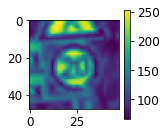

In [13]:
_st = f_start()
_folder = os.getcwd()+ "\\CSV\\"
_x_file = "x_train_gr_smpl.csv"
_y_file = "y_train_smpl.csv"
X = pd.read_csv(_folder+_x_file)
X.columns = ['x'+str(col) for col in X.columns]
y = pd.read_csv(_folder+_y_file)
y.columns = [*y.columns[:-1], 'label']
display(X.iloc[0:2,0:40])
plt.figure(figsize=(2,2))
plt.imshow(X.iloc[0:1].to_numpy().reshape(48,48))
plt.colorbar()
plt.grid(False)
# Class Definition
class_names = ['Speed Limit 20', 'Speed Limit 30', 'Speed Limit 50', 'Speed Limit 60', 'Speed Limit 70', 'Left Turn', 'Right Turn', 'Pedestrian', 'Children', 'Cycle Route']
print('Shape of X',X.shape,'Shape of y',y.shape)

ar_sm = np.apply_along_axis(func1d=lambda img: cv2.resize(img.reshape(48,48), dsize=(IMAGE_RESAMPLE,IMAGE_RESAMPLE)), axis=1, arr=X.to_numpy()).reshape(-1, IMAGE_RESAMPLE*IMAGE_RESAMPLE)
X = pd.DataFrame(data=ar_sm)
X.columns = ['x'+str(col) for col in X.columns]
f_end(_st)

# Data Preprocessing

Shape of X is (9690, 784)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24
0,0.294994,0.291175,0.327226,0.3803,0.463371,0.445727,0.4962,0.648221,0.927102,0.974885,0.943787,0.805312,0.618011,0.60998,0.700509,0.832959,0.938531,0.916429,0.77581,0.547939,0.334109,0.325265,0.383922,0.360597,0.306756


Shape of X (9690, 784) Shape of y (9690, 1)
Processed in 0.28 seconds.


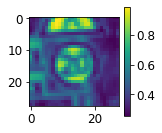

In [14]:
_st = f_start()
##### Normalization 
# For normalization we applied several techniques including Z Score however we selected the MinMaxScalar due to performance
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X = X.astype('float32')
print('Shape of X is',X.shape)
display(X.iloc[0:1,0:25])
print('Shape of X',X.shape,'Shape of y',y.shape)
plt.figure(figsize=(2,2))
plt.imshow(X.iloc[0:1].to_numpy().reshape(IMAGE_RESAMPLE,IMAGE_RESAMPLE))
plt.colorbar()
plt.grid(False)
f_end(_st)

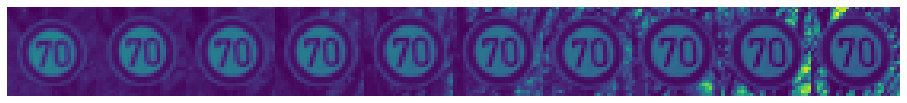

In [15]:
plt.figure(figsize=(16,16))
_plot_images=X.iloc[7400:7410].to_numpy()
f_PlotMultipleImages(_plot_images, images_per_row=10, size=IMAGE_RESAMPLE)
plt.show()

# Part 1 - Neural Network 

***

## Q1 - K10 Folds Cross Validation

In [16]:
kf = KFold(n_splits = NO_OF_KFOLDS)
skf = StratifiedKFold(n_splits=NO_OF_KFOLDS, shuffle=True, random_state=RANDOM_STATE)

In [17]:
kfolds_cvs = [] #Cross Validation Scores
kfolds_counter = 0
kfolds_cr  = {}  #Classification Report
kfolds_roc = {}  #For ROC and AUC Scores
kfolds_cm  = []  #Confusion Matrix 
kfolds_hist= {}  #Stores the Model History

for train, test in skf.split(X, y):
#     Model
    _model_seq = f_createModel()
    _model_seq.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy','mean_squared_error'])
    _model_seq.fit(X.to_numpy()[train], y.to_numpy()[train], epochs=NO_OF_EPOCHS)
    kfolds_hist[kfolds_counter+1] = _model_seq.fit(X.to_numpy()[train], y.to_numpy()[train], epochs=NO_OF_EPOCHS, validation_data=(X.to_numpy()[test], y.to_numpy()[test]))
    
    _scores = _model_seq.evaluate(X.to_numpy()[test], y.to_numpy()[test], verbose=0)
    _y_pred_class = np.argmax(_model_seq.predict(X.to_numpy()[test]),axis=-1)
    
    kfolds_roc[kfolds_counter] = f_ROC_AUC_Score_Multiclass(y.to_numpy()[test].ravel(), _y_pred_class)
    kfolds_cr[kfolds_counter] = sklearn.metrics.classification_report(y.to_numpy()[test], _y_pred_class, output_dict=True, zero_division=0)
    
    for key, value in kfolds_cr.items():
        for i_k, i_v in kfolds_cr[key].items():
            if type(kfolds_cr[key][i_k])==dict:
                kfolds_cr[key][i_k]['folds'] = int(key+1)

    kfolds_cm.append(sklearn.metrics.confusion_matrix(y.to_numpy()[test], _y_pred_class))
    kfolds_cvs.append(_scores[1] * 100)
    kfolds_counter+=1

Epoch 1/20
273/273 [==============================] - 0s 2ms/step - loss: 1.5862 - accuracy: 0.4332 - mean_squared_error: 14.0490
Epoch 2/20
273/273 [==============================] - 0s 1ms/step - loss: 1.1287 - accuracy: 0.6338 - mean_squared_error: 14.0591
Epoch 3/20
273/273 [==============================] - 0s 2ms/step - loss: 0.8849 - accuracy: 0.7393 - mean_squared_error: 14.0672
Epoch 4/20
273/273 [==============================] - 1s 2ms/step - loss: 0.7163 - accuracy: 0.8013 - mean_squared_error: 14.0747
Epoch 5/20
273/273 [==============================] - 0s 2ms/step - loss: 0.5993 - accuracy: 0.8394 - mean_squared_error: 14.0808
Epoch 6/20
273/273 [==============================] - 0s 1ms/step - loss: 0.5048 - accuracy: 0.8656 - mean_squared_error: 14.0861
Epoch 7/20
273/273 [==============================] - 0s 1ms/step - loss: 0.4415 - accuracy: 0.8838 - mean_squared_error: 14.0902
Epoch 8/20
273/273 [==============================] - 0s 1ms/step - loss: 0.3911 - accurac

273/273 [==============================] - 1s 2ms/step - loss: 0.3073 - accuracy: 0.9161 - mean_squared_error: 14.1008
Epoch 12/20
273/273 [==============================] - 1s 2ms/step - loss: 0.2760 - accuracy: 0.9264 - mean_squared_error: 14.1028
Epoch 13/20
273/273 [==============================] - 1s 2ms/step - loss: 0.2533 - accuracy: 0.9334 - mean_squared_error: 14.1039
Epoch 14/20
273/273 [==============================] - 0s 2ms/step - loss: 0.2546 - accuracy: 0.9314 - mean_squared_error: 14.1047
Epoch 15/20
273/273 [==============================] - 0s 1ms/step - loss: 0.2357 - accuracy: 0.9325 - mean_squared_error: 14.1059
Epoch 16/20
273/273 [==============================] - 0s 2ms/step - loss: 0.2507 - accuracy: 0.9289 - mean_squared_error: 14.1063
Epoch 17/20
273/273 [==============================] - 0s 2ms/step - loss: 0.1992 - accuracy: 0.9479 - mean_squared_error: 14.1081
Epoch 18/20
273/273 [==============================] - 0s 1ms/step - loss: 0.1919 - accuracy: 0

Epoch 2/20
273/273 [==============================] - 0s 1ms/step - loss: 0.1569 - accuracy: 0.9591 - mean_squared_error: 14.1118 - val_loss: 0.2071 - val_accuracy: 0.9463 - val_mean_squared_error: 14.1119
Epoch 3/20
273/273 [==============================] - 0s 2ms/step - loss: 0.1320 - accuracy: 0.9645 - mean_squared_error: 14.1126 - val_loss: 0.2017 - val_accuracy: 0.9484 - val_mean_squared_error: 14.1125
Epoch 4/20
273/273 [==============================] - 0s 2ms/step - loss: 0.1343 - accuracy: 0.9635 - mean_squared_error: 14.1130 - val_loss: 0.2085 - val_accuracy: 0.9494 - val_mean_squared_error: 14.1123
Epoch 5/20
273/273 [==============================] - 0s 1ms/step - loss: 0.1388 - accuracy: 0.9618 - mean_squared_error: 14.1131 - val_loss: 0.3498 - val_accuracy: 0.9102 - val_mean_squared_error: 14.1100
Epoch 6/20
273/273 [==============================] - 0s 1ms/step - loss: 0.1251 - accuracy: 0.9673 - mean_squared_error: 14.1137 - val_loss: 0.2145 - val_accuracy: 0.9432 - va

273/273 [==============================] - 0s 1ms/step - loss: 0.1338 - accuracy: 0.9653 - mean_squared_error: 14.1134 - val_loss: 0.2165 - val_accuracy: 0.9267 - val_mean_squared_error: 14.1119
Epoch 10/20
273/273 [==============================] - 0s 1ms/step - loss: 0.1250 - accuracy: 0.9663 - mean_squared_error: 14.1142 - val_loss: 0.1759 - val_accuracy: 0.9453 - val_mean_squared_error: 14.1129
Epoch 11/20
273/273 [==============================] - 0s 1ms/step - loss: 0.1175 - accuracy: 0.9681 - mean_squared_error: 14.1141 - val_loss: 0.2185 - val_accuracy: 0.9391 - val_mean_squared_error: 14.1125
Epoch 12/20
273/273 [==============================] - 0s 1ms/step - loss: 0.1174 - accuracy: 0.9685 - mean_squared_error: 14.1144 - val_loss: 0.2147 - val_accuracy: 0.9185 - val_mean_squared_error: 14.1130
Epoch 13/20
273/273 [==============================] - 0s 2ms/step - loss: 0.1175 - accuracy: 0.9647 - mean_squared_error: 14.1147 - val_loss: 0.1775 - val_accuracy: 0.9463 - val_mean_

Epoch 16/20
273/273 [==============================] - 0s 2ms/step - loss: 0.1511 - accuracy: 0.9559 - mean_squared_error: 14.1150 - val_loss: 0.1802 - val_accuracy: 0.9567 - val_mean_squared_error: 14.1152
Epoch 17/20
273/273 [==============================] - 0s 2ms/step - loss: 0.1066 - accuracy: 0.9679 - mean_squared_error: 14.1161 - val_loss: 0.1712 - val_accuracy: 0.9618 - val_mean_squared_error: 14.1155
Epoch 18/20
273/273 [==============================] - 1s 2ms/step - loss: 0.0740 - accuracy: 0.9811 - mean_squared_error: 14.1169 - val_loss: 0.3499 - val_accuracy: 0.9123 - val_mean_squared_error: 14.1137
Epoch 19/20
273/273 [==============================] - 1s 2ms/step - loss: 0.1061 - accuracy: 0.9693 - mean_squared_error: 14.1162 - val_loss: 0.1891 - val_accuracy: 0.9556 - val_mean_squared_error: 14.1155
Epoch 20/20
273/273 [==============================] - 0s 2ms/step - loss: 0.0882 - accuracy: 0.9763 - mean_squared_error: 14.1168 - val_loss: 0.2153 - val_accuracy: 0.9463

273/273 [==============================] - 0s 1ms/step - loss: 0.6493 - accuracy: 0.8197 - mean_squared_error: 14.0780
Epoch 5/20
273/273 [==============================] - 0s 1ms/step - loss: 0.5459 - accuracy: 0.8480 - mean_squared_error: 14.0844
Epoch 6/20
273/273 [==============================] - 0s 1ms/step - loss: 0.4564 - accuracy: 0.8788 - mean_squared_error: 14.0891
Epoch 7/20
273/273 [==============================] - 0s 1ms/step - loss: 0.3982 - accuracy: 0.8945 - mean_squared_error: 14.0929
Epoch 8/20
273/273 [==============================] - 0s 1ms/step - loss: 0.3716 - accuracy: 0.9020 - mean_squared_error: 14.0958
Epoch 9/20
273/273 [==============================] - 0s 1ms/step - loss: 0.3407 - accuracy: 0.9036 - mean_squared_error: 14.0981
Epoch 10/20
273/273 [==============================] - 0s 1ms/step - loss: 0.3041 - accuracy: 0.9179 - mean_squared_error: 14.1004
Epoch 11/20
273/273 [==============================] - 0s 2ms/step - loss: 0.2696 - accuracy: 0.9304

273/273 [==============================] - 0s 1ms/step - loss: 0.2474 - accuracy: 0.9340 - mean_squared_error: 14.1058
Epoch 16/20
273/273 [==============================] - 0s 1ms/step - loss: 0.2199 - accuracy: 0.9420 - mean_squared_error: 14.1069
Epoch 17/20
273/273 [==============================] - 0s 1ms/step - loss: 0.2073 - accuracy: 0.9426 - mean_squared_error: 14.1078
Epoch 18/20
273/273 [==============================] - 0s 1ms/step - loss: 0.2022 - accuracy: 0.9439 - mean_squared_error: 14.1084
Epoch 19/20
273/273 [==============================] - 0s 1ms/step - loss: 0.1933 - accuracy: 0.9478 - mean_squared_error: 14.1090
Epoch 20/20
273/273 [==============================] - 0s 1ms/step - loss: 0.1798 - accuracy: 0.9507 - mean_squared_error: 14.1098
Epoch 1/20
273/273 [==============================] - 1s 2ms/step - loss: 0.1767 - accuracy: 0.9512 - mean_squared_error: 14.1100 - val_loss: 0.2401 - val_accuracy: 0.9298 - val_mean_squared_error: 14.1101
Epoch 2/20
273/273 [

273/273 [==============================] - 0s 2ms/step - loss: 0.1469 - accuracy: 0.9583 - mean_squared_error: 14.1120 - val_loss: 0.1689 - val_accuracy: 0.9474 - val_mean_squared_error: 14.1116
Epoch 5/20
273/273 [==============================] - 0s 1ms/step - loss: 0.1463 - accuracy: 0.9611 - mean_squared_error: 14.1121 - val_loss: 0.1437 - val_accuracy: 0.9628 - val_mean_squared_error: 14.1124
Epoch 6/20
273/273 [==============================] - 0s 1ms/step - loss: 0.1437 - accuracy: 0.9614 - mean_squared_error: 14.1128 - val_loss: 0.1864 - val_accuracy: 0.9422 - val_mean_squared_error: 14.1114
Epoch 7/20
273/273 [==============================] - 0s 2ms/step - loss: 0.1473 - accuracy: 0.9576 - mean_squared_error: 14.1128 - val_loss: 0.1537 - val_accuracy: 0.9567 - val_mean_squared_error: 14.1127
Epoch 8/20
273/273 [==============================] - 0s 2ms/step - loss: 0.1314 - accuracy: 0.9653 - mean_squared_error: 14.1133 - val_loss: 0.1401 - val_accuracy: 0.9587 - val_mean_squa

273/273 [==============================] - 0s 1ms/step - loss: 0.1260 - accuracy: 0.9656 - mean_squared_error: 14.1139 - val_loss: 0.1935 - val_accuracy: 0.9515 - val_mean_squared_error: 14.1132
Epoch 12/20
273/273 [==============================] - 0s 1ms/step - loss: 0.1298 - accuracy: 0.9626 - mean_squared_error: 14.1142 - val_loss: 0.1668 - val_accuracy: 0.9546 - val_mean_squared_error: 14.1137
Epoch 13/20
273/273 [==============================] - 0s 1ms/step - loss: 0.1379 - accuracy: 0.9611 - mean_squared_error: 14.1144 - val_loss: 0.2647 - val_accuracy: 0.9391 - val_mean_squared_error: 14.1133
Epoch 14/20
273/273 [==============================] - 0s 1ms/step - loss: 0.1066 - accuracy: 0.9709 - mean_squared_error: 14.1149 - val_loss: 0.1854 - val_accuracy: 0.9515 - val_mean_squared_error: 14.1131
Epoch 15/20
273/273 [==============================] - 0s 1ms/step - loss: 0.1122 - accuracy: 0.9695 - mean_squared_error: 14.1151 - val_loss: 0.1962 - val_accuracy: 0.9505 - val_mean_

## Q2 - Visualization

#### Accuracy Plot

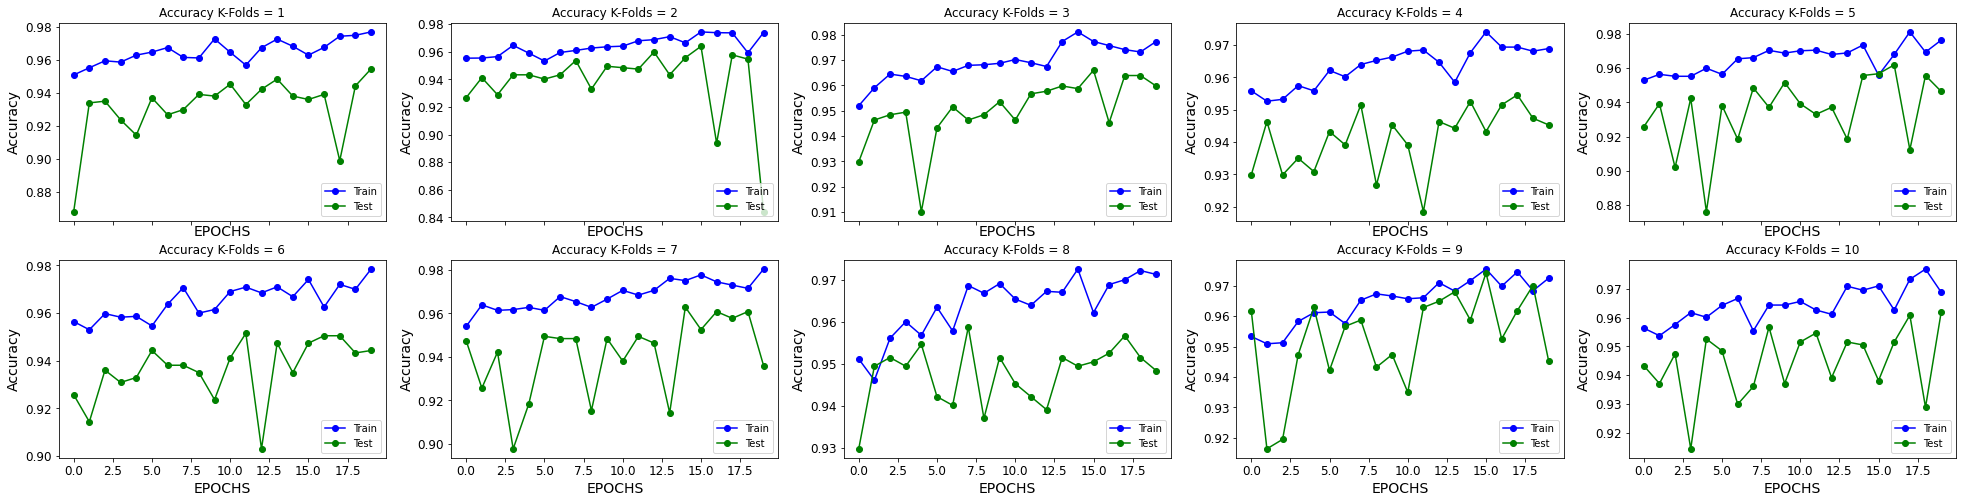

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(34,8))
for ax, _fold_counter in zip(axes.flatten(), kfolds_hist):
    ax.plot(kfolds_hist[_fold_counter].history['accuracy'], marker='o',label='Train', color='blue')
    ax.plot(kfolds_hist[_fold_counter].history['val_accuracy'], marker='o', label='Test', color='green')
    ax.set_title('Accuracy K-Folds = '+str(_fold_counter))
    ax.set(xlabel='EPOCHS', ylabel='Accuracy')
    ax.legend(loc='lower right')

#### Loss Plot

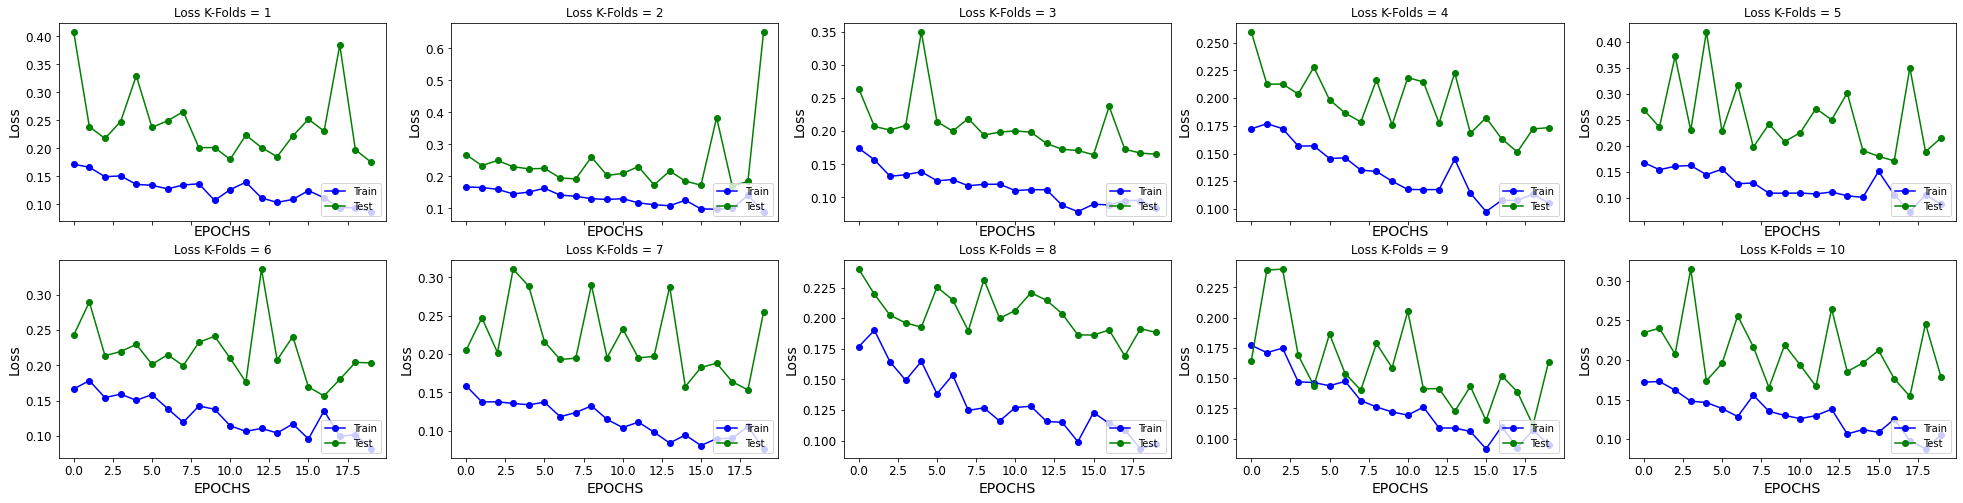

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(34,8))
for ax, _fold_counter in zip(axes.flatten(), kfolds_hist):
    ax.plot(kfolds_hist[_fold_counter].history['loss'], marker='o',label='Train', color='blue')
    ax.plot(kfolds_hist[_fold_counter].history['val_loss'], marker='o', label='Test', color='green')
    ax.set_title('Loss K-Folds = '+str(_fold_counter))
    ax.set(xlabel='EPOCHS', ylabel='Loss')
    ax.legend(loc='lower right')

#### Mean Squared Error Plot

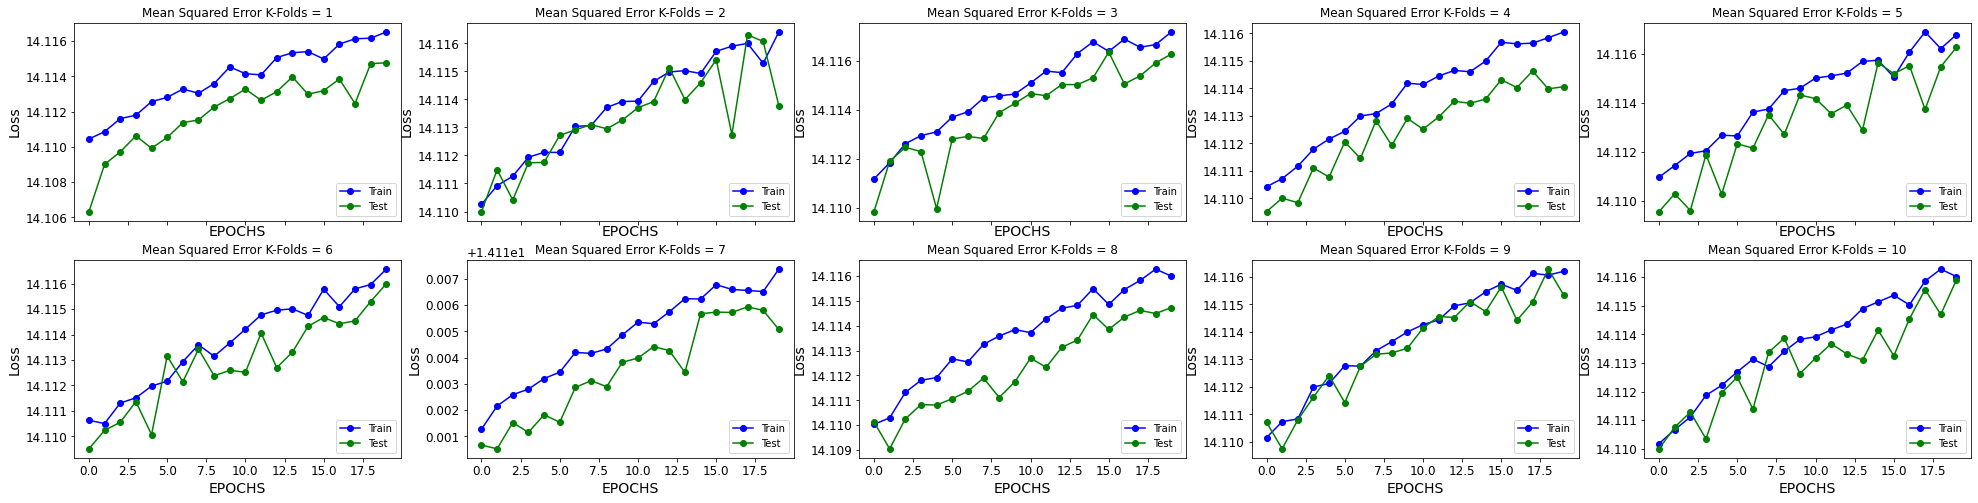

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(34,8))
for ax, _fold_counter in zip(axes.flatten(), kfolds_hist):
    ax.plot(kfolds_hist[_fold_counter].history['mean_squared_error'], marker='o',label='Train', color='blue')
    ax.plot(kfolds_hist[_fold_counter].history['val_mean_squared_error'], marker='o', label='Test', color='green')
    ax.set_title('Mean Squared Error K-Folds = '+str(_fold_counter))
    ax.set(xlabel='EPOCHS', ylabel='Loss')
    ax.legend(loc='lower right')

### Classification Report K-10 with ROC

In [21]:
np_roc = []
for key, value in kfolds_roc.items():
    kfolds_roc[key]['accuracy']=''
    kfolds_roc[key]['macro avg']=''
    kfolds_roc[key]['weighted avg']=''

for key, value in kfolds_roc.items():
    for i_k, i_v in value.items():
        np_roc.append(i_v)

In [22]:
df_folds_cl_rep = pd.DataFrame()
for folds in range(len(kfolds_cr)):
    df_folds_cl_rep = df_folds_cl_rep.append(pd.DataFrame(kfolds_cr[folds]).transpose(),ignore_index=False)
df_folds_cl_rep.loc['accuracy','precision']=''
df_folds_cl_rep.loc['accuracy','recall']=''
df_folds_cl_rep.loc['accuracy','folds']= np.NAN
df_folds_cl_rep = df_folds_cl_rep.fillna(method='ffill')
df_folds_cl_rep['roc_auc_score']=np_roc

In [23]:
df_folds_cl_rep

,precision,recall,f1-score,support,folds,roc_auc_score
0,0.952381,0.952381,0.952381,21.000000,1.0,0.975663
1,0.930435,0.963964,0.946903,222.000000,1.0,0.971272
2,0.951327,0.955556,0.953437,225.000000,1.0,0.970385
3,1,0.950355,0.974545,141.000000,1.0,0.975177
4,0.954774,0.959596,0.957179,198.000000,1.0,0.973961
5,0.9,0.857143,0.878049,21.000000,1.0,0.927517
6,1,0.888889,0.941176,36.000000,1.0,0.944444
7,1,1,1.000000,24.000000,1.0,1
8,0.931034,1,0.964286,54.000000,1.0,0.997814
9,0.96,0.888889,0.923077,27.000000,1.0,0.943914


### ROC AUC Score Plot

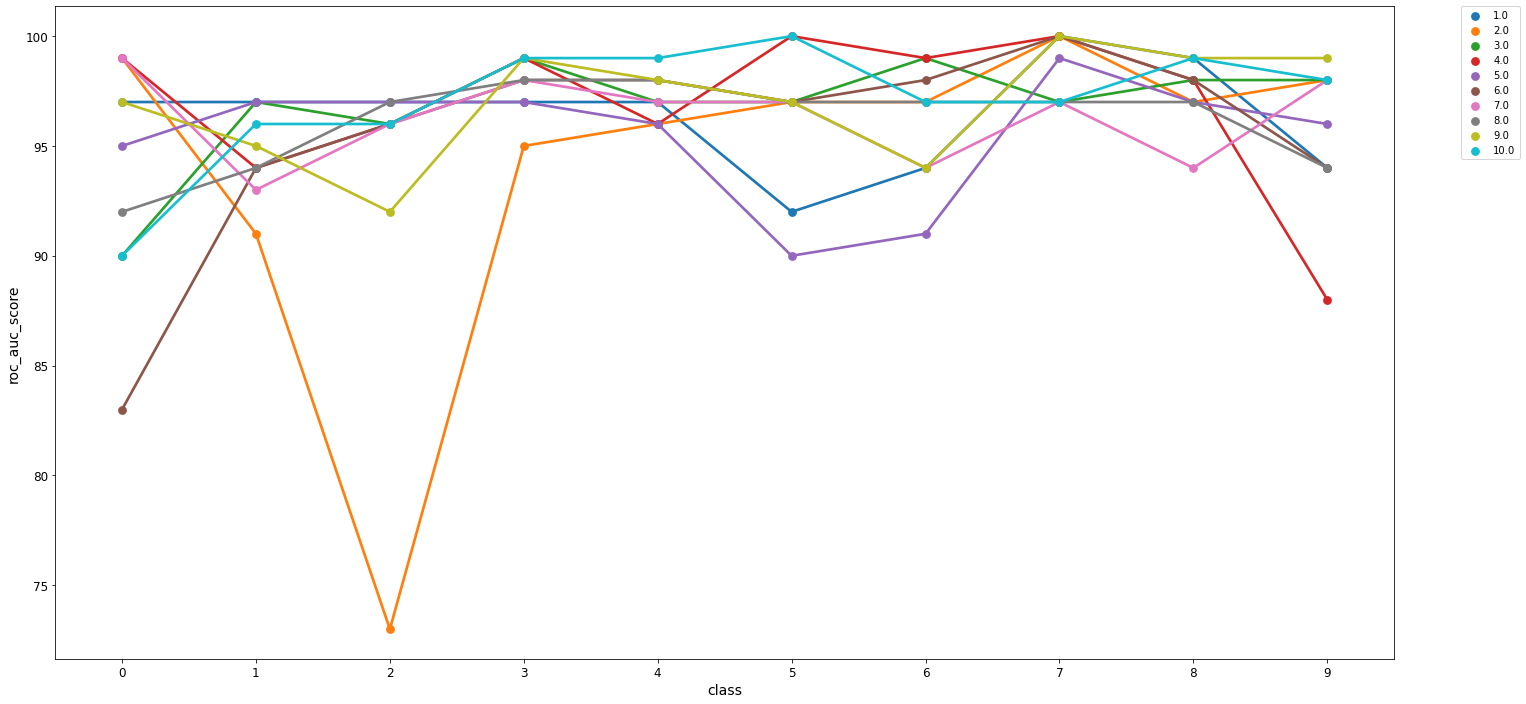

In [24]:
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(figsize=(24,12))
_data = df_folds_cl_rep[df_folds_cl_rep.roc_auc_score!='']
_data.loc[:,'roc_auc_score'] = _data.loc[:,'roc_auc_score'].apply(lambda x:x*100).astype(int)
_data = _data.reset_index()
_data.rename(columns={'index':'class'}, inplace=True)
palette = sns.color_palette("bright", 10)
ax = sns.pointplot(data=_data, x="class", y="roc_auc_score", hue='folds', marker='o', legend='full', palette='tab10', linewidth='2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Confusion Matrix K-10

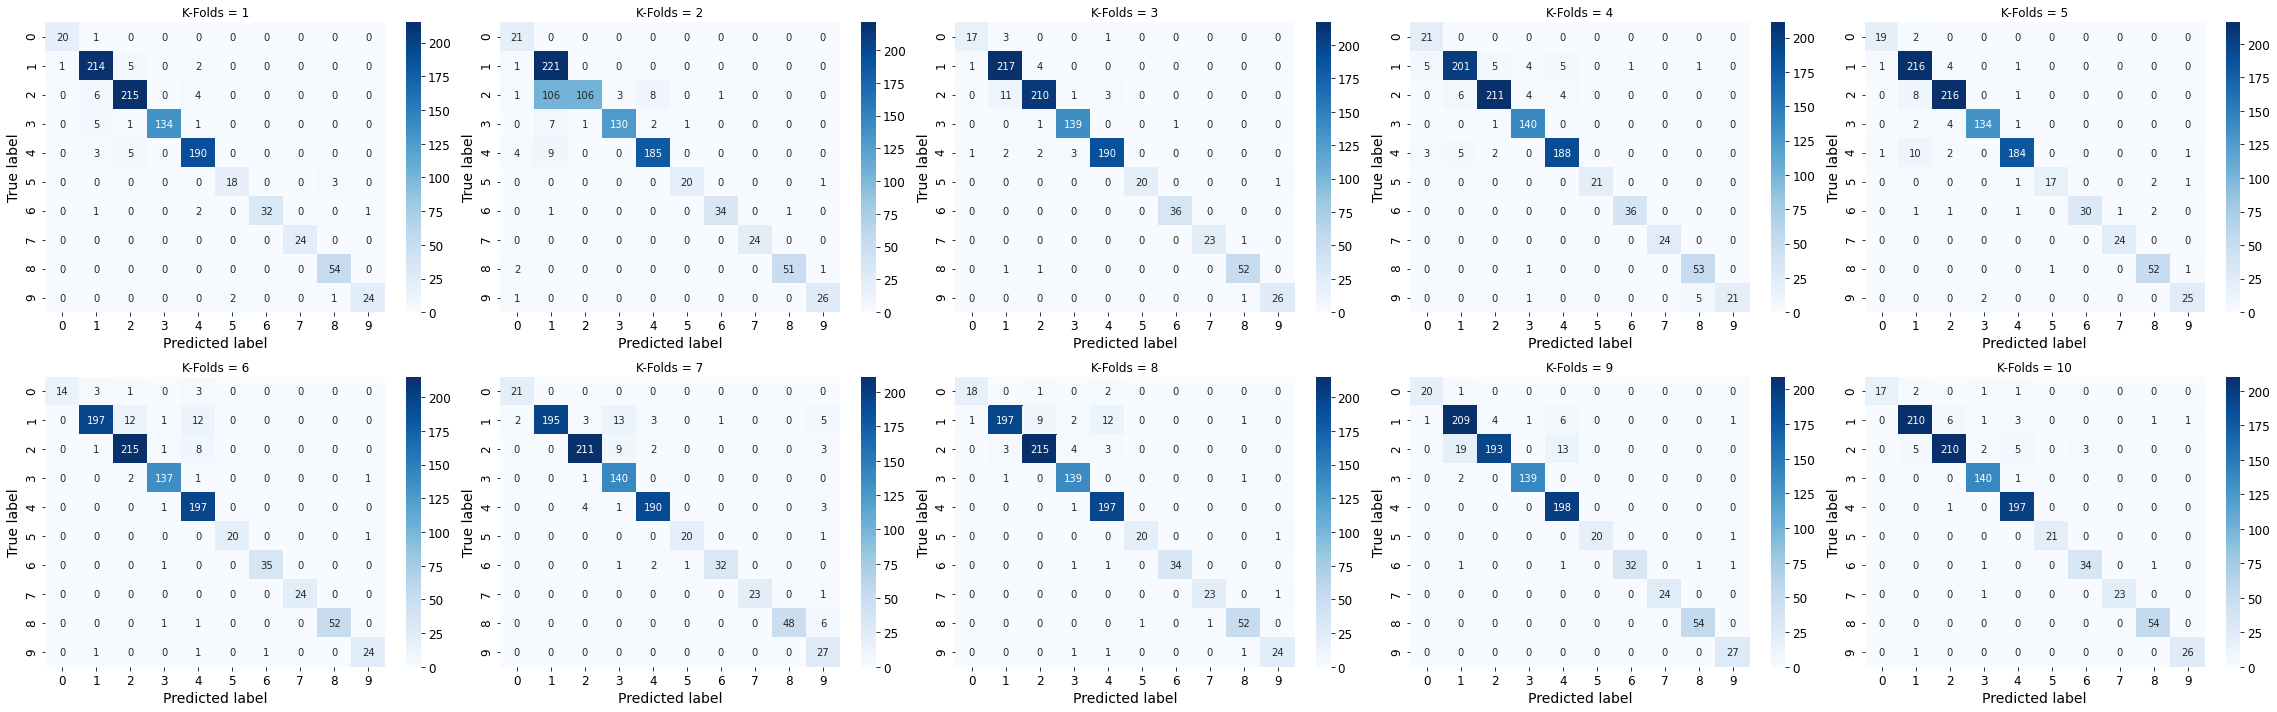

In [25]:
fig, axes = plt.subplots(2,5,figsize=(32,10))
for _fold_counter in range(len(kfolds_cm)):
    row = _fold_counter // 5
    col = _fold_counter % 5
    ax_curr = axes[row, col]
    sns.heatmap(kfolds_cm[_fold_counter], annot=True, cmap=plt.cm.Blues, fmt='g', ax=ax_curr)
    _chart_title = 'K-Folds = '+str(_fold_counter+1)
    ax_curr.set_title(_chart_title)
    ax_curr.set(xlabel='Predicted label', ylabel='True label')
    plt.tight_layout()

### Cross Validation Scores

In [26]:
df_folds_cvs = pd.DataFrame(kfolds_cvs)
df_folds_cvs.columns = ['cross_validation_score']
df_folds_cvs['k_folds'] = range(1,NO_OF_KFOLDS+1)
df_folds_cvs['epochs'] = NO_OF_EPOCHS
df_folds_cvs.sort_values(by=['cross_validation_score'], ascending=False)

,cross_validation_score,k_folds,epochs
9,96.181631,10,20
2,95.975232,3,20
0,95.459235,1,20
7,94.840044,8,20
4,94.633645,5,20
3,94.530445,4,20
8,94.530445,9,20
5,94.427246,6,20
6,93.601650,7,20
1,84.416926,2,20


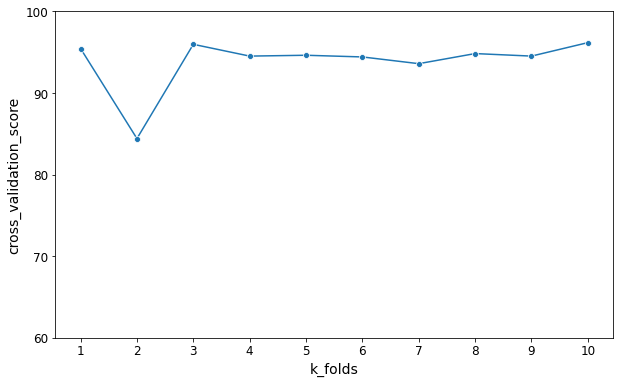

In [27]:
fig, axes = plt.subplots(figsize=(10,6))
ax = sns.lineplot(data=df_folds_cvs, x="k_folds", y="cross_validation_score", marker='o')
ax.set(xticks=df_folds_cvs.k_folds.values)
ax.set(yticks=np.arange(6,11)*10)
plt.show()

In [28]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(kfolds_cvs), np.std(kfolds_cvs)))

93.86% (+/- 3.23%)


## Question No. 3

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)
print('X_train', X_train.shape, 'X_test', X_test.shape, 'y_train', y_train.shape, 'y_test', y_test.shape)

X_train (7752, 784) X_test (1938, 784) y_train (7752, 1) y_test (1938, 1)


### Model Evaluation

In [30]:
if os.path.exists("logs/fit/seq/") : shutil.rmtree("logs/fit/seq/")
model_seq = f_createModel()
model_seq.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model_seq.fit(X_train, y_train, epochs=NO_OF_EPOCHS, validation_data=(X_test, y_test))
    
log_dir = "logs/fit/seq/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
es_callback = EarlyStopping(monitor='loss', patience=3) # This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs
model_seq.fit(x=X_train, 
              y=y_train, 
              epochs=NO_OF_EPOCHS, 
              verbose=0,
              callbacks=[tensorboard_callback,es_callback],
              validation_data=(X_test, y_test),
             )
test_loss, test_acc = model_seq.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy:', test_acc)
%reload_ext tensorboard
# %tensorboard --logdir logs/fit/seq/ --host localhost --port 8088
# Launch http://localhost:8088/

Epoch 1/20
243/243 [==============================] - 0s 2ms/step - loss: 1.6029 - accuracy: 0.4355 - val_loss: 1.3260 - val_accuracy: 0.5402
Epoch 2/20
243/243 [==============================] - 0s 1ms/step - loss: 1.1579 - accuracy: 0.6254 - val_loss: 1.0352 - val_accuracy: 0.6698
Epoch 3/20
243/243 [==============================] - 0s 2ms/step - loss: 0.9259 - accuracy: 0.7310 - val_loss: 0.8354 - val_accuracy: 0.7786
Epoch 4/20
243/243 [==============================] - 0s 2ms/step - loss: 0.7252 - accuracy: 0.8012 - val_loss: 0.7275 - val_accuracy: 0.8153
Epoch 5/20
243/243 [==============================] - 0s 1ms/step - loss: 0.6532 - accuracy: 0.8141 - val_loss: 0.5865 - val_accuracy: 0.8277
Epoch 6/20
243/243 [==============================] - 0s 1ms/step - loss: 0.5276 - accuracy: 0.8594 - val_loss: 0.6364 - val_accuracy: 0.7962
Epoch 7/20
243/243 [==============================] - 0s 1ms/step - loss: 0.4736 - accuracy: 0.8728 - val_loss: 0.4707 - val_accuracy: 0.8669
Epoch 

In [31]:
model_seq.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_21 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


#### Bad Predictions

In [32]:
y_pred_train = model_seq.predict(X.to_numpy())
bad_predictions = (y_pred_train.argmax(axis=1) != y.to_numpy().ravel())
print('Total bad predictions are', sum(bad_predictions))

Total bad predictions are 363


#### Accurancy and Loss Plot

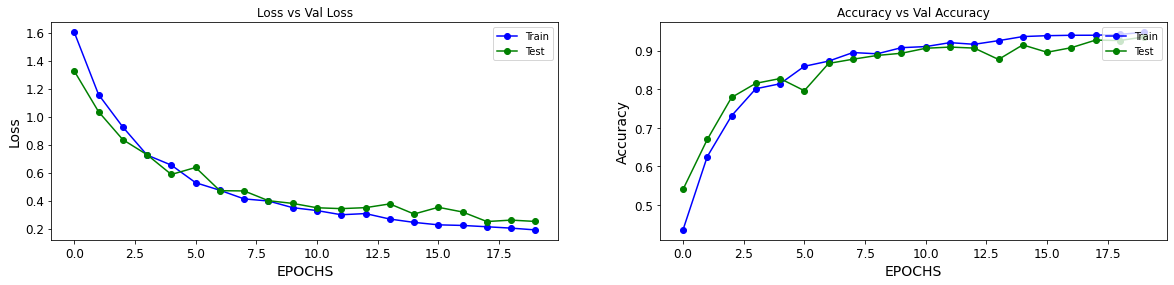

In [33]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,4))
ax1.plot(history.history['loss'], marker='o', label='Train', color='b')
ax1.plot(history.history['val_loss'], marker='o', label='Test', color='g')
ax1.set_title('Loss vs Val Loss')
ax1.set(xlabel='EPOCHS', ylabel='Loss')
ax1.legend(loc='upper right')
ax2.plot(history.history['accuracy'], marker='o', label='Train', color='b')
ax2.plot(history.history['val_accuracy'], marker='o', label='Test', color='g')
ax2.set_title('Accuracy vs Val Accuracy')
ax2.set(xlabel='EPOCHS', ylabel='Accuracy')
ax2.legend(loc='upper right')

### Predictions

In [34]:
y_predict = model_seq.predict(X_test)
y_pred_class = np.argmax(model_seq.predict(X_test), axis=-1) #predict_classes is depereciated

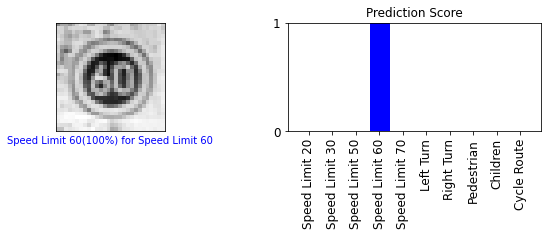

In [35]:
f_PlotPresentPredictions(PREDICT_RECORD, y_predict[PREDICT_RECORD], y_test, X_test)

### Classification Report

In [36]:
roc_auc_score = f_ROC_AUC_Score_Multiclass(y_test.to_numpy().ravel(),y_pred_class)

In [37]:
roc_auc_score['accuracy']=''
roc_auc_score['macro avg']=''
roc_auc_score['weighted avg']=''
np_roc = []
for key, value in roc_auc_score.items():
    np_roc.append(value)

In [38]:
_classification_report = sklearn.metrics.classification_report(y_test, y_pred_class, output_dict=True)
df_seq_cr = pd.DataFrame(_classification_report).transpose()
df_seq_cr.loc['accuracy','precision']=''
df_seq_cr.loc['accuracy','recall']=''
df_seq_cr['roc_auc_score'] = np_roc
df_seq_cr

,precision,recall,f1-score,support,roc_auc_score
0,0.970588,0.804878,0.880000,41.000000,0.902175
1,0.973105,0.910755,0.940898,437.000000,0.951713
2,0.939597,0.950226,0.944882,442.000000,0.966089
3,0.97318,0.951311,0.962121,267.000000,0.973561
4,0.899782,0.983333,0.939704,420.000000,0.976515
5,1,0.857143,0.923077,42.000000,0.928571
6,0.971429,0.906667,0.937931,75.000000,0.952797
7,1,0.98,0.989899,50.000000,0.99
8,0.931624,1,0.964602,109.000000,0.997813
9,0.928571,0.945455,0.936937,55.000000,0.971665


In [39]:
df_seq_cr.reset_index(inplace=True)
df_seq_cr = df_seq_cr.rename(columns = {'index':'Measure','f1-score':'f1_score'})
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='0', class_names[0], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='1', class_names[1], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='2', class_names[2], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='3', class_names[3], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='4', class_names[4], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='5', class_names[5], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='6', class_names[6], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='7', class_names[7], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='8', class_names[8], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='9', class_names[9], df_seq_cr['Measure'])
df_seq_cr

,Measure,precision,recall,f1_score,support,roc_auc_score
0,Speed Limit 20,0.970588,0.804878,0.880000,41.000000,0.902175
1,Speed Limit 30,0.973105,0.910755,0.940898,437.000000,0.951713
2,Speed Limit 50,0.939597,0.950226,0.944882,442.000000,0.966089
3,Speed Limit 60,0.97318,0.951311,0.962121,267.000000,0.973561
4,Speed Limit 70,0.899782,0.983333,0.939704,420.000000,0.976515
5,Left Turn,1,0.857143,0.923077,42.000000,0.928571
6,Right Turn,0.971429,0.906667,0.937931,75.000000,0.952797
7,Pedestrian,1,0.98,0.989899,50.000000,0.99
8,Children,0.931624,1,0.964602,109.000000,0.997813
9,Cycle Route,0.928571,0.945455,0.936937,55.000000,0.971665


### ROC AUC Score Plot

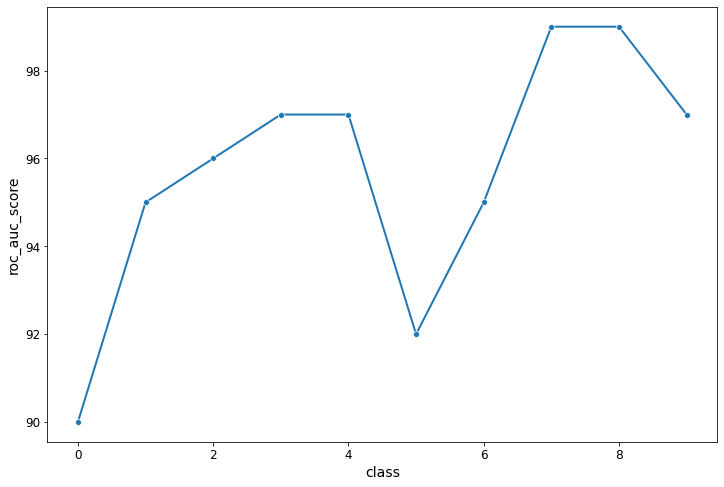

In [40]:
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(figsize=(12,8))
_data = df_seq_cr[df_seq_cr.roc_auc_score!='']
_data.loc[:,'roc_auc_score'] = _data.loc[:,'roc_auc_score'].apply(lambda x:x*100).astype(int)
_data = _data.reset_index()
_data.rename(columns={'index':'class'}, inplace=True)
palette = sns.color_palette("bright", 10)
ax = sns.lineplot(data=_data, x="class", y="roc_auc_score",  marker='o', palette='tab10', linewidth='2')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Confusion Matrix

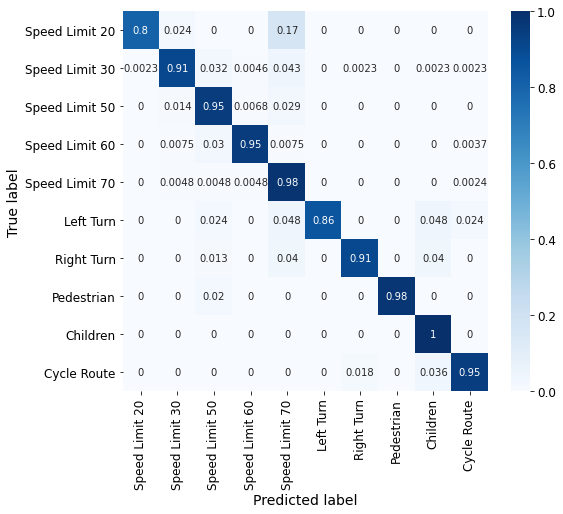

In [41]:
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred_class).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=5)
con_mat_df = pd.DataFrame(con_mat_norm,index = class_names, columns = class_names)
con_mat_df
figure = plt.figure(figsize=(8, 7))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### TP, TN, FP, FN

In [42]:
df_seq_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, y_pred_class))
df_seq_cm.columns=class_names
df_seq_cm.index = class_names
df_seq_cm

,Speed Limit 20,Speed Limit 30,Speed Limit 50,Speed Limit 60,Speed Limit 70,Left Turn,Right Turn,Pedestrian,Children,Cycle Route
Speed Limit 20,33,1,0,0,7,0,0,0,0,0
Speed Limit 30,1,398,14,2,19,0,1,0,1,1
Speed Limit 50,0,6,420,3,13,0,0,0,0,0
Speed Limit 60,0,2,8,254,2,0,0,0,0,1
Speed Limit 70,0,2,2,2,413,0,0,0,0,1
Left Turn,0,0,1,0,2,36,0,0,2,1
Right Turn,0,0,1,0,3,0,68,0,3,0
Pedestrian,0,0,1,0,0,0,0,49,0,0
Children,0,0,0,0,0,0,0,0,109,0
Cycle Route,0,0,0,0,0,0,1,0,2,52


<AxesSubplot:title={'center':'Confusion Matrix (TP, TN, FP, FN)'}>

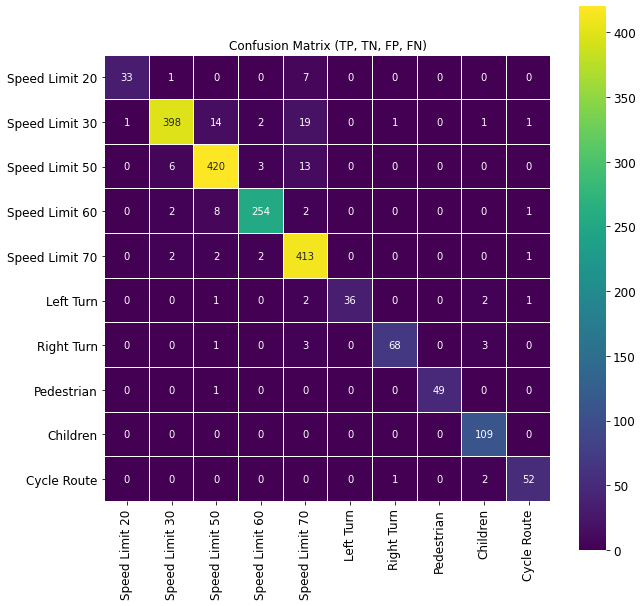

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Confusion Matrix (TP, TN, FP, FN)')
sns.heatmap(df_seq_cm, 
            cmap="viridis",
            fmt=".0f",
            annot_kws={"fontsize":10},
            square=True,
            annot=True,
           linewidths=.01,
           ax=ax)

### Grid Search

In [44]:
model = KerasClassifier(build_fn=f_ModelGridSearch, verbose=5)
optimizers = ['adam']
init = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(epochs=GS_EPOCHS, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=5, return_train_score=False, n_jobs=-1, cv=None)

In [45]:
grid_result = grid.fit(X, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  8.1min finished


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


In [46]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.578844 using {'epochs': 20, 'init': 'glorot_uniform'}


In [47]:
gr_results = grid_result.cv_results_

In [48]:
scores_df = pd.DataFrame(gr_results).sort_values(by=['param_epochs','param_init'])
scores_df = scores_df.drop(['params'], axis=1)
scores_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_epochs,param_init,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,3.065812,0.296593,1.249615,0.282743,1,glorot_normal,0.420537,0.243034,0.072755,0.044376,0.123839,0.180908,0.137751,29
5,2.787259,0.279775,1.533263,0.198431,1,glorot_uniform,0.033024,0.238906,0.034056,0.065531,0.133643,0.101032,0.078031,35
6,3.187280,0.207571,1.593371,0.169612,1,he_normal,0.053148,0.152735,0.291022,0.031476,0.055728,0.116821,0.096650,31
7,3.515897,0.055570,1.102113,0.116640,1,he_uniform,0.013416,0.235810,0.272962,0.048504,0.130547,0.140248,0.101334,30
1,2.915061,0.476806,1.294295,0.164875,1,lecun_uniform,0.204850,0.212074,0.005160,0.026832,0.107843,0.111352,0.086394,34
2,2.679839,0.178237,1.177862,0.168241,1,normal,0.225490,0.176471,0.015480,0.022188,0.120227,0.111971,0.083050,33
0,2.862447,0.063880,1.402805,0.080180,1,uniform,0.189370,0.224974,0.009804,0.021156,0.120227,0.113106,0.086611,32
3,2.669793,0.295325,1.374380,0.208762,1,zero,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36
12,8.819555,0.547308,2.208410,0.945549,5,glorot_normal,0.164087,0.418473,0.259546,0.199690,0.152735,0.238906,0.097192,28
13,8.865213,0.604409,2.092503,0.501229,5,glorot_uniform,0.403509,0.634675,0.371001,0.236326,0.152219,0.359546,0.164880,22


In [49]:
print('Optimal Combination',grid_result.best_params_)

Optimal Combination {'epochs': 20, 'init': 'glorot_uniform'}


## Question No. 4

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.60, random_state=RANDOM_STATE)
print('X_train', X_train.shape, 'X_test', X_test.shape, 'y_train', y_train.shape, 'y_test', y_test.shape)

X_train (3876, 784) X_test (5814, 784) y_train (3876, 1) y_test (5814, 1)


### Model Evaluation

In [51]:
if os.path.exists("logs/fit/seq/") : shutil.rmtree("logs/fit/seq/")
model_seq = f_createModel()
model_seq.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model_seq.fit(X_train, y_train, epochs=NO_OF_EPOCHS, validation_data=(X_test, y_test))
log_dir = "logs/fit/seq/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
es_callback = EarlyStopping(monitor='loss', patience=3) # This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs
model_seq.fit(x=X_train, 
              y=y_train, 
              epochs=NO_OF_EPOCHS, 
              verbose=0,
              callbacks=[tensorboard_callback,es_callback],
              validation_data=(X_test, y_test),
             )
test_loss, test_acc = model_seq.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy:', test_acc)
# %reload_ext tensorboard
# %tensorboard --logdir logs/fit/seq/ --host localhost --port 8088
# Launch http://localhost:8088/

Epoch 1/20
122/122 [==============================] - 0s 3ms/step - loss: 1.7444 - accuracy: 0.3916 - val_loss: 1.5526 - val_accuracy: 0.4718
Epoch 2/20
122/122 [==============================] - 0s 3ms/step - loss: 1.4144 - accuracy: 0.5124 - val_loss: 1.3438 - val_accuracy: 0.5320
Epoch 3/20
122/122 [==============================] - 0s 3ms/step - loss: 1.2390 - accuracy: 0.5746 - val_loss: 1.1929 - val_accuracy: 0.5822
Epoch 4/20
122/122 [==============================] - 0s 4ms/step - loss: 1.0660 - accuracy: 0.6651 - val_loss: 1.0293 - val_accuracy: 0.6964
Epoch 5/20
122/122 [==============================] - 0s 4ms/step - loss: 0.9267 - accuracy: 0.7288 - val_loss: 0.8831 - val_accuracy: 0.7614
Epoch 6/20
122/122 [==============================] - 0s 3ms/step - loss: 0.8404 - accuracy: 0.7503 - val_loss: 0.8692 - val_accuracy: 0.7282
Epoch 7/20
122/122 [==============================] - 0s 3ms/step - loss: 0.7556 - accuracy: 0.7851 - val_loss: 0.7738 - val_accuracy: 0.7707
Epoch 

#### Bad Predictions

In [52]:
y_pred_train = model_seq.predict(X.to_numpy())
bad_predictions = (y_pred_train.argmax(axis=1) != y.to_numpy().ravel())
print('Total bad predictions are', sum(bad_predictions))

Total bad predictions are 579


#### Accurancy and Loss Plot

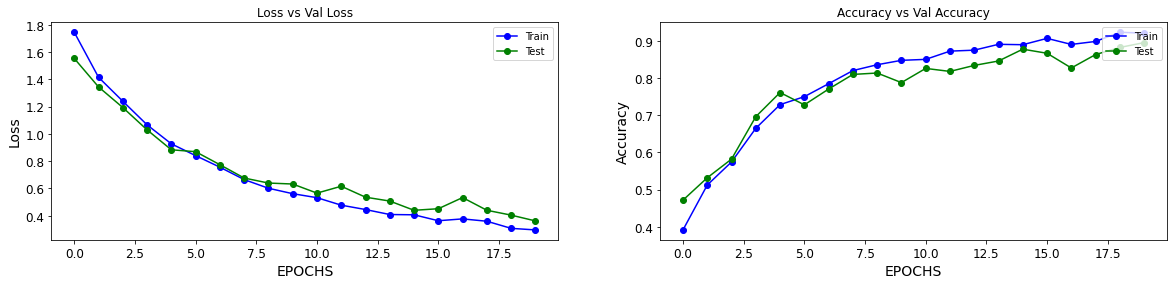

In [53]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,4))
ax1.plot(history.history['loss'], marker='o', label='Train', color='b')
ax1.plot(history.history['val_loss'], marker='o', label='Test', color='g')
ax1.set_title('Loss vs Val Loss')
ax1.set(xlabel='EPOCHS', ylabel='Loss')
ax1.legend(loc='upper right')
ax2.plot(history.history['accuracy'], marker='o', label='Train', color='b')
ax2.plot(history.history['val_accuracy'], marker='o', label='Test', color='g')
ax2.set_title('Accuracy vs Val Accuracy')
ax2.set(xlabel='EPOCHS', ylabel='Accuracy')
ax2.legend(loc='upper right')

### Predictions

In [54]:
y_predict = model_seq.predict(X_test)
y_pred_class = np.argmax(model_seq.predict(X_test), axis=-1) #predict_classes is depereciated

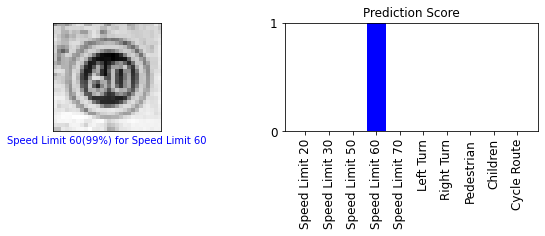

In [55]:
PREDICT_RECORD=15
f_PlotPresentPredictions(PREDICT_RECORD, y_predict[PREDICT_RECORD], y_test, X_test)

### Classification Report

In [56]:
roc_auc_score = f_ROC_AUC_Score_Multiclass(y_test.to_numpy().ravel(),y_pred_class)

In [57]:
roc_auc_score['accuracy']=''
roc_auc_score['macro avg']=''
roc_auc_score['weighted avg']=''
np_roc = []
for key, value in roc_auc_score.items():
    np_roc.append(value)

In [58]:
_classification_report = sklearn.metrics.classification_report(y_test, y_pred_class, output_dict=True)
df_seq_cr = pd.DataFrame(_classification_report).transpose()
df_seq_cr.loc['accuracy','precision']=''
df_seq_cr.loc['accuracy','recall']=''
df_seq_cr['roc_auc_score'] = np_roc
df_seq_cr

,precision,recall,f1-score,support,roc_auc_score
0,0.979798,0.782258,0.869955,124.000000,0.890953
1,0.934468,0.861176,0.896327,1275.000000,0.922106
2,0.876494,0.952381,0.912863,1386.000000,0.955188
3,0.956469,0.942789,0.949580,839.000000,0.967776
4,0.924171,0.966144,0.944691,1211.000000,0.972644
5,0.972973,0.907563,0.939130,119.000000,0.953518
6,0.913462,0.88785,0.900474,214.000000,0.942318
7,0.987013,0.980645,0.983819,155.000000,0.990146
8,0.986532,0.890578,0.936102,329.000000,0.944924
9,0.877193,0.925926,0.900901,162.000000,0.961105


In [59]:
df_seq_cr.reset_index(inplace=True)
df_seq_cr = df_seq_cr.rename(columns = {'index':'Measure','f1-score':'f1_score'})
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='0', class_names[0], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='1', class_names[1], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='2', class_names[2], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='3', class_names[3], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='4', class_names[4], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='5', class_names[5], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='6', class_names[6], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='7', class_names[7], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='8', class_names[8], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='9', class_names[9], df_seq_cr['Measure'])
df_seq_cr

,Measure,precision,recall,f1_score,support,roc_auc_score
0,Speed Limit 20,0.979798,0.782258,0.869955,124.000000,0.890953
1,Speed Limit 30,0.934468,0.861176,0.896327,1275.000000,0.922106
2,Speed Limit 50,0.876494,0.952381,0.912863,1386.000000,0.955188
3,Speed Limit 60,0.956469,0.942789,0.949580,839.000000,0.967776
4,Speed Limit 70,0.924171,0.966144,0.944691,1211.000000,0.972644
5,Left Turn,0.972973,0.907563,0.939130,119.000000,0.953518
6,Right Turn,0.913462,0.88785,0.900474,214.000000,0.942318
7,Pedestrian,0.987013,0.980645,0.983819,155.000000,0.990146
8,Children,0.986532,0.890578,0.936102,329.000000,0.944924
9,Cycle Route,0.877193,0.925926,0.900901,162.000000,0.961105


### ROC AUC Score Plot

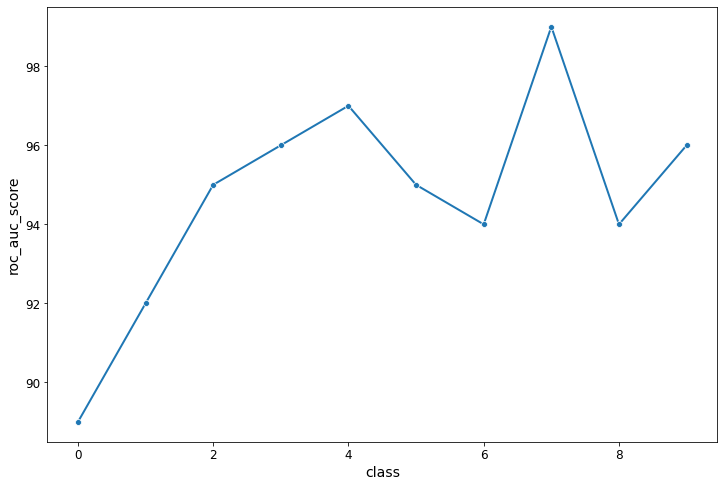

In [60]:
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(figsize=(12,8))
_data = df_seq_cr[df_seq_cr.roc_auc_score!='']
_data.loc[:,'roc_auc_score'] = _data.loc[:,'roc_auc_score'].apply(lambda x:x*100).astype(int)
_data = _data.reset_index()
_data.rename(columns={'index':'class'}, inplace=True)
palette = sns.color_palette("bright", 10)
ax = sns.lineplot(data=_data, x="class", y="roc_auc_score",  marker='o', palette='tab10', linewidth='2')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Confusion Matrix

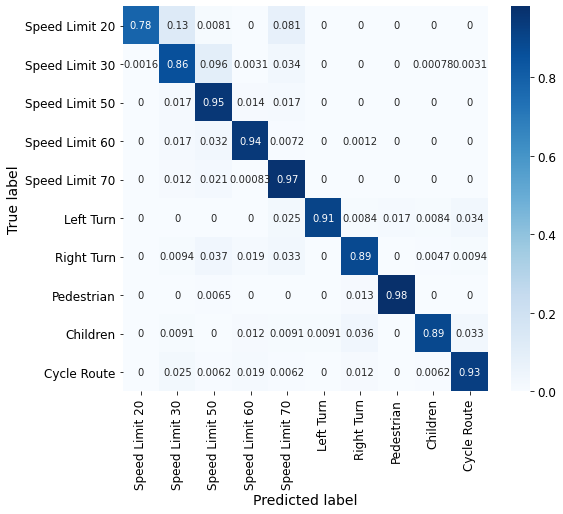

In [61]:
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred_class).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=5)
con_mat_df = pd.DataFrame(con_mat_norm,index = class_names, columns = class_names)
con_mat_df
figure = plt.figure(figsize=(8, 7))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### TP, TN, FP, FN

In [62]:
df_seq_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, y_pred_class))
df_seq_cm.columns=class_names
df_seq_cm.index = class_names
df_seq_cm

,Speed Limit 20,Speed Limit 30,Speed Limit 50,Speed Limit 60,Speed Limit 70,Left Turn,Right Turn,Pedestrian,Children,Cycle Route
Speed Limit 20,97,16,1,0,10,0,0,0,0,0
Speed Limit 30,2,1098,123,4,43,0,0,0,1,4
Speed Limit 50,0,23,1320,20,23,0,0,0,0,0
Speed Limit 60,0,14,27,791,6,0,1,0,0,0
Speed Limit 70,0,15,25,1,1170,0,0,0,0,0
Left Turn,0,0,0,0,3,108,1,2,1,4
Right Turn,0,2,8,4,7,0,190,0,1,2
Pedestrian,0,0,1,0,0,0,2,152,0,0
Children,0,3,0,4,3,3,12,0,293,11
Cycle Route,0,4,1,3,1,0,2,0,1,150


<AxesSubplot:title={'center':'Confusion Matrix (TP, TN, FP, FN)'}>

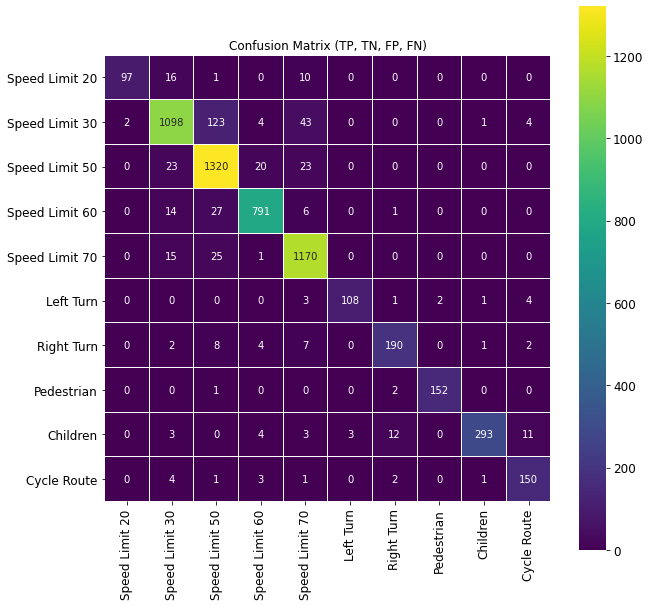

In [63]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Confusion Matrix (TP, TN, FP, FN)')
sns.heatmap(df_seq_cm, 
            cmap="viridis",
            fmt=".0f",
            annot_kws={"fontsize":10},
            square=True,
            annot=True,
           linewidths=.01,
           ax=ax)

### Grid Search

In [64]:
model = KerasClassifier(build_fn=f_ModelGridSearch, verbose=5)
optimizers = ['adam']
init = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(epochs=GS_EPOCHS, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=5, return_train_score=False, n_jobs=-1, cv=None)

In [65]:
grid_result = grid.fit(X, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  7.9min finished


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


In [66]:
gr_results = grid_result.cv_results_

In [67]:
scores_df = pd.DataFrame(gr_results).sort_values(by=['param_epochs','param_init'])
scores_df = scores_df.drop(['params'], axis=1)
scores_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_epochs,param_init,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,3.177935,0.506224,1.223672,0.546284,1,glorot_normal,0.101651,0.320949,0.281734,0.094943,0.111455,0.182147,0.098250,30
5,2.717460,0.331255,1.327659,0.297846,1,glorot_uniform,0.202270,0.211042,0.008772,0.074303,0.105779,0.120433,0.077095,33
6,2.668460,0.333875,1.406303,0.366298,1,he_normal,0.047472,0.204850,0.211042,0.101651,0.113519,0.135707,0.063077,32
7,2.976530,0.222539,1.196802,0.119982,1,he_uniform,0.301858,0.301858,0.232198,0.058824,0.097523,0.198452,0.102183,29
1,2.538836,0.255577,1.345439,0.333599,1,lecun_uniform,0.254386,0.303922,0.107843,0.007740,0.128483,0.160475,0.106318,31
2,2.849397,0.290670,1.253240,0.198141,1,normal,0.047472,0.257998,0.006708,0.041796,0.102683,0.091331,0.088820,35
0,2.527268,0.159449,1.157461,0.092482,1,uniform,0.038184,0.176471,0.114551,0.018576,0.118163,0.093189,0.057634,34
3,2.888925,0.452547,1.511887,0.283711,1,zero,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36
12,9.045577,1.028670,2.440094,0.740093,5,glorot_normal,0.345717,0.574819,0.268834,0.324045,0.152219,0.333127,0.138215,24
13,9.268062,0.524969,1.556867,0.449245,5,glorot_uniform,0.415893,0.676471,0.325077,0.292570,0.157895,0.373581,0.172608,23


In [68]:
print('Optimal Combination',grid_result.best_params_)

Optimal Combination {'epochs': 20, 'init': 'he_uniform'}


## Question No. 5

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.93, random_state=RANDOM_STATE)
print('X_train', X_train.shape, 'X_test', X_test.shape, 'y_train', y_train.shape, 'y_test', y_test.shape)

X_train (678, 784) X_test (9012, 784) y_train (678, 1) y_test (9012, 1)


### Model Evaluation

In [70]:
if os.path.exists("logs/fit/seq/") : shutil.rmtree("logs/fit/seq/")
model_seq = f_createModel()
model_seq.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model_seq.fit(X_train, y_train, epochs=NO_OF_EPOCHS, validation_data=(X_test, y_test))

log_dir = "logs/fit/seq/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
es_callback = EarlyStopping(monitor='loss', patience=3) # This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs
model_seq.fit(x=X_train, 
              y=y_train, 
              epochs=NO_OF_EPOCHS, 
              verbose=0,
              callbacks=[tensorboard_callback,es_callback],
              validation_data=(X_test, y_test),
             )
test_loss, test_acc = model_seq.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy:', test_acc)
%reload_ext tensorboard
# %tensorboard --logdir logs/fit/seq/ --host localhost --port 8088
# Launch http://localhost:8088/

Epoch 1/20
22/22 [==============================] - 1s 23ms/step - loss: 2.0557 - accuracy: 0.2493 - val_loss: 1.8556 - val_accuracy: 0.3232
Epoch 2/20
22/22 [==============================] - 0s 17ms/step - loss: 1.8519 - accuracy: 0.3245 - val_loss: 1.7523 - val_accuracy: 0.3533
Epoch 3/20
22/22 [==============================] - 0s 18ms/step - loss: 1.7369 - accuracy: 0.4012 - val_loss: 1.6809 - val_accuracy: 0.4460
Epoch 4/20
22/22 [==============================] - 0s 17ms/step - loss: 1.6435 - accuracy: 0.4189 - val_loss: 1.6395 - val_accuracy: 0.3889
Epoch 5/20
22/22 [==============================] - 0s 15ms/step - loss: 1.5836 - accuracy: 0.4292 - val_loss: 1.5498 - val_accuracy: 0.4776
Epoch 6/20
22/22 [==============================] - 0s 15ms/step - loss: 1.4809 - accuracy: 0.5074 - val_loss: 1.5196 - val_accuracy: 0.4436
Epoch 7/20
22/22 [==============================] - 0s 15ms/step - loss: 1.4194 - accuracy: 0.5059 - val_loss: 1.4860 - val_accuracy: 0.4834
Epoch 8/20
22

#### Bad Predictions

In [71]:
y_pred_train = model_seq.predict(X.to_numpy())
bad_predictions = (y_pred_train.argmax(axis=1) != y.to_numpy().ravel())
print('Total bad predictions are', sum(bad_predictions))

Total bad predictions are 2491


#### Accurancy and Loss Plot

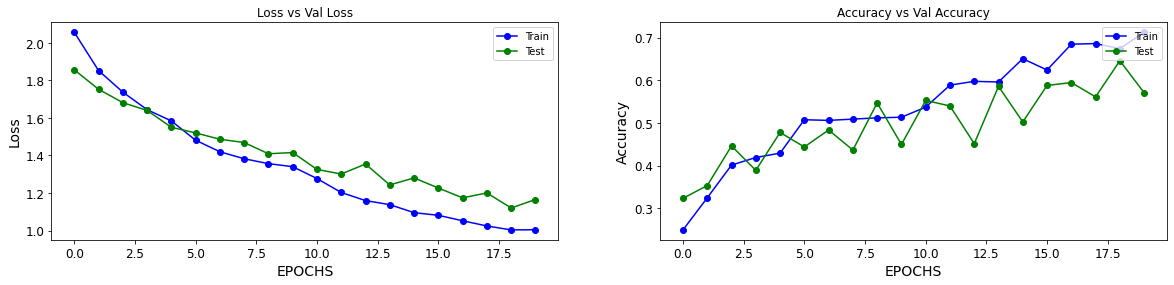

In [72]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,4))
ax1.plot(history.history['loss'], marker='o', label='Train', color='b')
ax1.plot(history.history['val_loss'], marker='o', label='Test', color='g')
ax1.set_title('Loss vs Val Loss')
ax1.set(xlabel='EPOCHS', ylabel='Loss')
ax1.legend(loc='upper right')
ax2.plot(history.history['accuracy'], marker='o', label='Train', color='b')
ax2.plot(history.history['val_accuracy'], marker='o', label='Test', color='g')
ax2.set_title('Accuracy vs Val Accuracy')
ax2.set(xlabel='EPOCHS', ylabel='Accuracy')
ax2.legend(loc='upper right')

### Predictions

In [73]:
y_predict = model_seq.predict(X_test)
y_pred_class = np.argmax(model_seq.predict(X_test), axis=-1) #predict_classes is depereciated

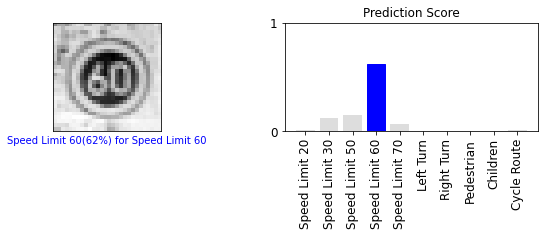

In [74]:
PREDICT_RECORD=15
f_PlotPresentPredictions(PREDICT_RECORD, y_predict[PREDICT_RECORD], y_test, X_test)

### Classification Report

In [75]:
roc_auc_score = f_ROC_AUC_Score_Multiclass(y_test.to_numpy().ravel(),y_pred_class)

In [76]:
roc_auc_score['accuracy']=''
roc_auc_score['macro avg']=''
roc_auc_score['weighted avg']=''
np_roc = []
for key, value in roc_auc_score.items():
    np_roc.append(value)

In [77]:
_classification_report = sklearn.metrics.classification_report(y_test, y_pred_class, output_dict=True)
df_seq_cr = pd.DataFrame(_classification_report).transpose()
df_seq_cr.loc['accuracy','precision']=''
df_seq_cr.loc['accuracy','recall']=''
df_seq_cr['roc_auc_score'] = np_roc
df_seq_cr

,precision,recall,f1-score,support,roc_auc_score
0,0.948718,0.193717,0.321739,191.000000,0.596745
1,0.796139,0.677295,0.731924,2070.000000,0.81279
2,0.621379,0.852816,0.718931,2113.000000,0.846831
3,0.785388,0.784791,0.785089,1315.000000,0.874077
4,0.80226,0.777656,0.789766,1826.000000,0.864475
5,0.765517,0.584211,0.662687,190.000000,0.790178
6,0.624642,0.650746,0.637427,335.000000,0.817824
7,0.89881,0.683258,0.776350,221.000000,0.840662
8,0.82151,0.719439,0.767094,499.000000,0.855138
9,0.542636,0.277778,0.367454,252.000000,0.635521


In [78]:
df_seq_cr.reset_index(inplace=True)
df_seq_cr = df_seq_cr.rename(columns = {'index':'Measure','f1-score':'f1_score'})
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='0', class_names[0], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='1', class_names[1], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='2', class_names[2], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='3', class_names[3], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='4', class_names[4], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='5', class_names[5], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='6', class_names[6], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='7', class_names[7], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='8', class_names[8], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='9', class_names[9], df_seq_cr['Measure'])
df_seq_cr

,Measure,precision,recall,f1_score,support,roc_auc_score
0,Speed Limit 20,0.948718,0.193717,0.321739,191.000000,0.596745
1,Speed Limit 30,0.796139,0.677295,0.731924,2070.000000,0.81279
2,Speed Limit 50,0.621379,0.852816,0.718931,2113.000000,0.846831
3,Speed Limit 60,0.785388,0.784791,0.785089,1315.000000,0.874077
4,Speed Limit 70,0.80226,0.777656,0.789766,1826.000000,0.864475
5,Left Turn,0.765517,0.584211,0.662687,190.000000,0.790178
6,Right Turn,0.624642,0.650746,0.637427,335.000000,0.817824
7,Pedestrian,0.89881,0.683258,0.776350,221.000000,0.840662
8,Children,0.82151,0.719439,0.767094,499.000000,0.855138
9,Cycle Route,0.542636,0.277778,0.367454,252.000000,0.635521


### ROC AUC Score Plot

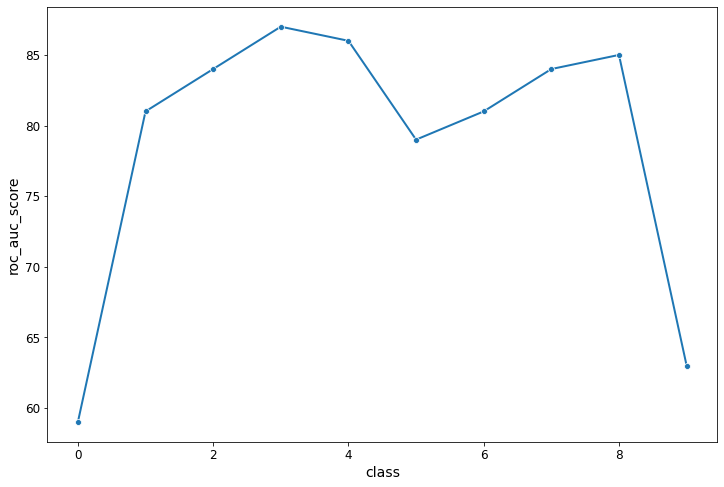

In [79]:
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(figsize=(12,8))
_data = df_seq_cr[df_seq_cr.roc_auc_score!='']
_data.loc[:,'roc_auc_score'] = _data.loc[:,'roc_auc_score'].apply(lambda x:x*100).astype(int)
_data = _data.reset_index()
_data.rename(columns={'index':'class'}, inplace=True)
palette = sns.color_palette("bright", 10)
ax = sns.lineplot(data=_data, x="class", y="roc_auc_score",  marker='o', palette='tab10', linewidth='2')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Confusion Matrix

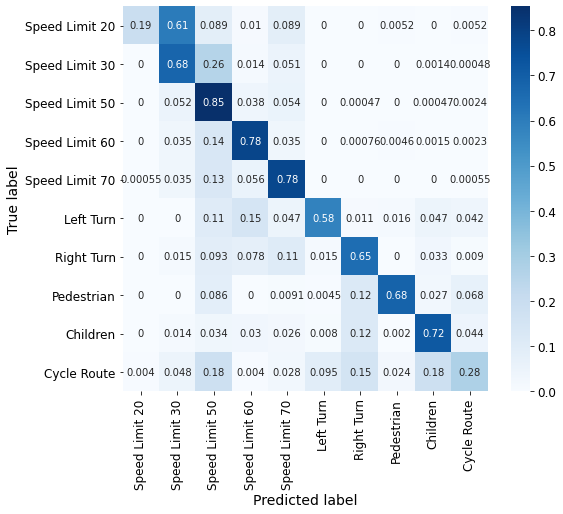

In [80]:
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred_class).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=5)
con_mat_df = pd.DataFrame(con_mat_norm,index = class_names, columns = class_names)
con_mat_df
figure = plt.figure(figsize=(8, 7))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### TP, TN, FP, FN

In [81]:
df_seq_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, y_pred_class))
df_seq_cm.columns=class_names
df_seq_cm.index = class_names
df_seq_cm

,Speed Limit 20,Speed Limit 30,Speed Limit 50,Speed Limit 60,Speed Limit 70,Left Turn,Right Turn,Pedestrian,Children,Cycle Route
Speed Limit 20,37,116,17,2,17,0,0,1,0,1
Speed Limit 30,0,1402,531,28,105,0,0,0,3,1
Speed Limit 50,0,109,1802,80,115,0,1,0,1,5
Speed Limit 60,0,46,179,1032,46,0,1,6,2,3
Speed Limit 70,1,64,238,102,1420,0,0,0,0,1
Left Turn,0,0,20,28,9,111,2,3,9,8
Right Turn,0,5,31,26,36,5,218,0,11,3
Pedestrian,0,0,19,0,2,1,27,151,6,15
Children,0,7,17,15,13,4,61,1,359,22
Cycle Route,1,12,46,1,7,24,39,6,46,70


<AxesSubplot:title={'center':'Confusion Matrix (TP, TN, FP, FN)'}>

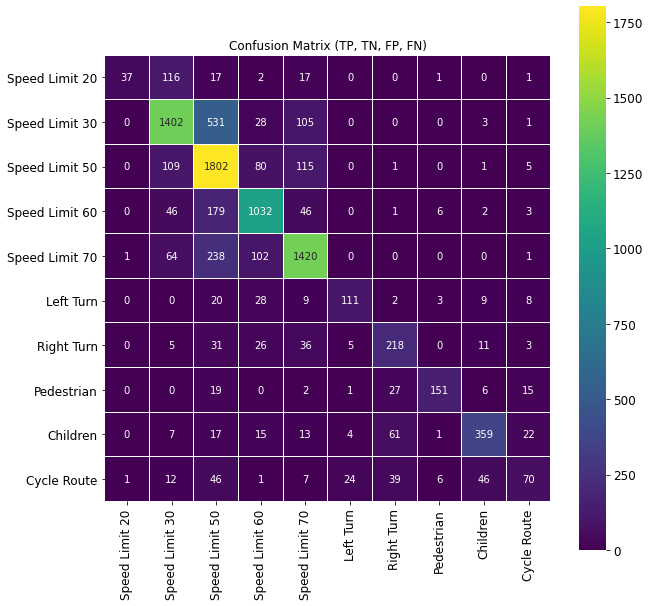

In [82]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Confusion Matrix (TP, TN, FP, FN)')
sns.heatmap(df_seq_cm, 
            cmap="viridis",
            fmt=".0f",
            annot_kws={"fontsize":10},
            square=True,
            annot=True,
           linewidths=.01,
           ax=ax)

### Grid Search

In [83]:
model = KerasClassifier(build_fn=f_ModelGridSearch, verbose=5)
optimizers = ['adam']
init = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(epochs=GS_EPOCHS, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=5, return_train_score=False, n_jobs=-1, cv=None)

In [84]:
grid_result = grid.fit(X, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  8.0min finished


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


In [85]:
gr_results = grid_result.cv_results_

In [86]:
scores_df = pd.DataFrame(gr_results).sort_values(by=['param_epochs','param_init'])
scores_df = scores_df.drop(['params'], axis=1)
scores_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_epochs,param_init,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,3.548703,0.305915,1.128120,0.216317,1,glorot_normal,0.145511,0.107843,0.069659,0.078947,0.113003,0.102993,0.026910,32
5,2.804241,0.128907,1.268362,0.126842,1,glorot_uniform,0.206914,0.212074,0.094427,0.019608,0.093911,0.125387,0.073892,31
6,3.239640,0.137504,1.032999,0.044059,1,he_normal,0.257482,0.262642,0.266770,0.029928,0.097007,0.182766,0.099733,30
7,3.172800,0.148535,1.193799,0.036118,1,he_uniform,0.466460,0.297214,0.019092,0.042828,0.100619,0.185243,0.171272,29
1,3.263601,0.728084,1.358001,0.211957,1,lecun_uniform,0.000516,0.336945,0.015480,0.028896,0.115067,0.099381,0.125271,34
2,3.392197,0.392834,1.404198,0.076926,1,normal,0.071723,0.126935,0.028380,0.037152,0.076367,0.068111,0.034867,35
0,2.998203,0.614970,1.664798,0.164122,1,uniform,0.051084,0.142931,0.174407,0.014448,0.123839,0.101342,0.059415,33
3,3.480670,0.524588,1.350633,0.222759,1,zero,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36
12,9.329009,0.539391,1.650200,0.335294,5,glorot_normal,0.494324,0.355005,0.292570,0.296182,0.151187,0.317853,0.110823,24
13,8.368289,0.850506,2.083790,0.532729,5,glorot_uniform,0.147059,0.579979,0.261610,0.277606,0.149123,0.283075,0.158169,27


In [87]:
print('Optimal Combination',grid_result.best_params_)

Optimal Combination {'epochs': 20, 'init': 'uniform'}


# Part 2 - CNN

## Q1 - K10 Folds Cross Validation

In [88]:
XX = X.to_numpy().reshape(9690,IMAGE_RESAMPLE,IMAGE_RESAMPLE,1)
print('New X',XX.shape,'Y',y.shape)

New X (9690, 28, 28, 1) Y (9690, 1)


In [89]:
kf = KFold(n_splits = NO_OF_KFOLDS)
skf = StratifiedKFold(n_splits=NO_OF_KFOLDS, shuffle=True, random_state=RANDOM_STATE)

In [90]:
kfolds_cvs = [] #Cross Validation Scores
kfolds_counter = 0
kfolds_cr  = {}  #Classification Report
kfolds_roc = {}  #For ROC and AUC Scores
kfolds_cm  = []  #Confusion Matrix 
kfolds_hist= {}  #Stores the Model History

for train, test in skf.split(XX, y):
    _model_cnn = f_createCNNModel()
    _model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy','mean_squared_error'])
    kfolds_hist[kfolds_counter+1] = _model_cnn.fit(XX[train], y.to_numpy()[train], epochs=NO_OF_EPOCHS, validation_data=(XX[test], y.to_numpy()[test]))
        
    _model_cnn.fit(XX[train], y.to_numpy()[train], epochs=NO_OF_EPOCHS)
    _scores = _model_cnn.evaluate(XX[test], y.to_numpy()[test], verbose=0)
    _y_pred_class = np.argmax(_model_cnn.predict(XX[test]),axis=-1)
    
    kfolds_roc[kfolds_counter] = f_ROC_AUC_Score_Multiclass(y.to_numpy()[test].ravel(), _y_pred_class)
    kfolds_cr[kfolds_counter] = sklearn.metrics.classification_report(y.to_numpy()[test], _y_pred_class, output_dict=True, zero_division=0)
    
    for key, value in kfolds_cr.items():
        for i_k, i_v in kfolds_cr[key].items():
            if type(kfolds_cr[key][i_k])==dict:
                kfolds_cr[key][i_k]['folds'] = int(key+1)

    kfolds_cm.append(sklearn.metrics.confusion_matrix(y.to_numpy()[test], _y_pred_class))
    kfolds_cvs.append(_scores[1] * 100)
    kfolds_counter+=1

Epoch 1/20
273/273 [==============================] - 10s 36ms/step - loss: 1.2624 - accuracy: 0.5501 - mean_squared_error: 14.0594 - val_loss: 0.4469 - val_accuracy: 0.8679 - val_mean_squared_error: 14.0914
Epoch 2/20
273/273 [==============================] - 10s 37ms/step - loss: 0.2540 - accuracy: 0.9276 - mean_squared_error: 14.1039 - val_loss: 0.2139 - val_accuracy: 0.9340 - val_mean_squared_error: 14.1100
Epoch 3/20
273/273 [==============================] - 8s 29ms/step - loss: 0.1121 - accuracy: 0.9705 - mean_squared_error: 14.1140 - val_loss: 0.0838 - val_accuracy: 0.9856 - val_mean_squared_error: 14.1161
Epoch 4/20
273/273 [==============================] - 9s 32ms/step - loss: 0.0640 - accuracy: 0.9839 - mean_squared_error: 14.1178 - val_loss: 0.0735 - val_accuracy: 0.9845 - val_mean_squared_error: 14.1183
Epoch 5/20
273/273 [==============================] - 10s 37ms/step - loss: 0.0394 - accuracy: 0.9907 - mean_squared_error: 14.1198 - val_loss: 0.0448 - val_accuracy: 0.9

273/273 [==============================] - 8s 30ms/step - loss: 0.0364 - accuracy: 0.9904 - mean_squared_error: 14.1201 - val_loss: 0.0558 - val_accuracy: 0.9876 - val_mean_squared_error: 14.1208
Epoch 7/20
273/273 [==============================] - 8s 29ms/step - loss: 0.0321 - accuracy: 0.9914 - mean_squared_error: 14.1209 - val_loss: 0.0560 - val_accuracy: 0.9866 - val_mean_squared_error: 14.1212
Epoch 8/20
273/273 [==============================] - 8s 29ms/step - loss: 0.0173 - accuracy: 0.9970 - mean_squared_error: 14.1217 - val_loss: 0.0454 - val_accuracy: 0.9886 - val_mean_squared_error: 14.1218
Epoch 9/20
273/273 [==============================] - 8s 28ms/step - loss: 0.0107 - accuracy: 0.9982 - mean_squared_error: 14.1222 - val_loss: 0.0968 - val_accuracy: 0.9773 - val_mean_squared_error: 14.1208
Epoch 10/20
273/273 [==============================] - 8s 30ms/step - loss: 0.0190 - accuracy: 0.9952 - mean_squared_error: 14.1218 - val_loss: 0.0393 - val_accuracy: 0.9907 - val_mea

273/273 [==============================] - 8s 28ms/step - loss: 0.0038 - accuracy: 0.9995 - mean_squared_error: 14.1230 - val_loss: 0.0399 - val_accuracy: 0.9948 - val_mean_squared_error: 14.1224
Epoch 13/20
273/273 [==============================] - 7s 27ms/step - loss: 0.0024 - accuracy: 0.9999 - mean_squared_error: 14.1231 - val_loss: 0.0387 - val_accuracy: 0.9938 - val_mean_squared_error: 14.1223
Epoch 14/20
273/273 [==============================] - 7s 27ms/step - loss: 0.0019 - accuracy: 0.9999 - mean_squared_error: 14.1232 - val_loss: 0.0392 - val_accuracy: 0.9948 - val_mean_squared_error: 14.1225
Epoch 15/20
273/273 [==============================] - 7s 27ms/step - loss: 0.0014 - accuracy: 1.0000 - mean_squared_error: 14.1233 - val_loss: 0.0420 - val_accuracy: 0.9928 - val_mean_squared_error: 14.1227
Epoch 16/20
273/273 [==============================] - 8s 29ms/step - loss: 0.0012 - accuracy: 1.0000 - mean_squared_error: 14.1233 - val_loss: 0.0420 - val_accuracy: 0.9948 - val_

Epoch 18/20
273/273 [==============================] - 8s 29ms/step - loss: 0.0018 - accuracy: 0.9995 - mean_squared_error: 14.1233 - val_loss: 0.0112 - val_accuracy: 0.9969 - val_mean_squared_error: 14.1231
Epoch 19/20
273/273 [==============================] - 8s 29ms/step - loss: 6.1218e-04 - accuracy: 1.0000 - mean_squared_error: 14.1234 - val_loss: 0.0124 - val_accuracy: 0.9969 - val_mean_squared_error: 14.1232
Epoch 20/20
273/273 [==============================] - 8s 28ms/step - loss: 4.1034e-04 - accuracy: 1.0000 - mean_squared_error: 14.1235 - val_loss: 0.0110 - val_accuracy: 0.9969 - val_mean_squared_error: 14.1232
Epoch 1/20
273/273 [==============================] - 8s 28ms/step - loss: 3.4085e-04 - accuracy: 1.0000 - mean_squared_error: 14.1235 0s - loss: 3.4139e-04 - accuracy: 1.00
Epoch 2/20
273/273 [==============================] - 7s 27ms/step - loss: 2.8628e-04 - accuracy: 1.0000 - mean_squared_error: 14.1235
Epoch 3/20
273/273 [==============================] - 8s 28

273/273 [==============================] - 8s 29ms/step - loss: 3.4882e-04 - accuracy: 1.0000 - mean_squared_error: 14.1235 1s - loss: 3.5162e-04 
Epoch 5/20
273/273 [==============================] - 8s 28ms/step - loss: 2.9749e-04 - accuracy: 1.0000 - mean_squared_error: 14.1235
Epoch 6/20
273/273 [==============================] - 8s 28ms/step - loss: 3.8703e-04 - accuracy: 1.0000 - mean_squared_error: 14.1235
Epoch 7/20
273/273 [==============================] - 7s 27ms/step - loss: 2.6865e-04 - accuracy: 1.0000 - mean_squared_error: 14.1235
Epoch 8/20
273/273 [==============================] - 8s 28ms/step - loss: 0.0552 - accuracy: 0.9837 - mean_squared_error: 14.1212
Epoch 9/20
273/273 [==============================] - 7s 27ms/step - loss: 0.0094 - accuracy: 0.9976 - mean_squared_error: 14.1227
Epoch 10/20
273/273 [==============================] - 7s 27ms/step - loss: 0.0011 - accuracy: 1.0000 - mean_squared_error: 14.1234
Epoch 11/20
273/273 [==============================] -

273/273 [==============================] - 8s 28ms/step - loss: 6.2183e-05 - accuracy: 1.0000 - mean_squared_error: 14.1235
Epoch 13/20
273/273 [==============================] - 7s 27ms/step - loss: 5.4555e-05 - accuracy: 1.0000 - mean_squared_error: 14.1235 1s - loss: 4.9488e-05 
Epoch 14/20
273/273 [==============================] - 8s 28ms/step - loss: 4.6803e-05 - accuracy: 1.0000 - mean_squared_error: 14.1235
Epoch 15/20
273/273 [==============================] - 8s 28ms/step - loss: 3.9272e-05 - accuracy: 1.0000 - mean_squared_error: 14.1235
Epoch 16/20
273/273 [==============================] - 8s 30ms/step - loss: 0.0607 - accuracy: 0.9845 - mean_squared_error: 14.1216 1s - los
Epoch 17/20
273/273 [==============================] - 8s 28ms/step - loss: 0.0114 - accuracy: 0.9968 - mean_squared_error: 14.1227
Epoch 18/20
273/273 [==============================] - 8s 28ms/step - loss: 0.0022 - accuracy: 0.9998 - mean_squared_error: 14.1232
Epoch 19/20
273/273 [===================

273/273 [==============================] - 7s 27ms/step - loss: 1.6053e-04 - accuracy: 1.0000 - mean_squared_error: 14.1235
Epoch 20/20
273/273 [==============================] - 7s 27ms/step - loss: 1.2941e-04 - accuracy: 1.0000 - mean_squared_error: 14.1235 0s - loss: 1.3008e-04 - accuracy: 1.0000 - mean_squared_error: 14.
Epoch 1/20
273/273 [==============================] - 8s 29ms/step - loss: 1.2741 - accuracy: 0.5379 - mean_squared_error: 14.0586 - val_loss: 0.4824 - val_accuracy: 0.8658 - val_mean_squared_error: 14.0859
Epoch 2/20
273/273 [==============================] - 7s 27ms/step - loss: 0.2632 - accuracy: 0.9251 - mean_squared_error: 14.1026 - val_loss: 0.1493 - val_accuracy: 0.9659 - val_mean_squared_error: 14.1098
Epoch 3/20
273/273 [==============================] - 8s 29ms/step - loss: 0.1054 - accuracy: 0.9733 - mean_squared_error: 14.1143 - val_loss: 0.0985 - val_accuracy: 0.9814 - val_mean_squared_error: 14.1156
Epoch 4/20
273/273 [==============================] 

Epoch 5/20
273/273 [==============================] - 7s 26ms/step - loss: 0.0501 - accuracy: 0.9864 - mean_squared_error: 14.1193 - val_loss: 0.0572 - val_accuracy: 0.9835 - val_mean_squared_error: 14.1196
Epoch 6/20
273/273 [==============================] - 8s 28ms/step - loss: 0.0369 - accuracy: 0.9909 - mean_squared_error: 14.1205 - val_loss: 0.0333 - val_accuracy: 0.9907 - val_mean_squared_error: 14.1211
Epoch 7/20
273/273 [==============================] - 7s 27ms/step - loss: 0.0286 - accuracy: 0.9925 - mean_squared_error: 14.1211 - val_loss: 0.0414 - val_accuracy: 0.9856 - val_mean_squared_error: 14.1210
Epoch 8/20
273/273 [==============================] - 8s 28ms/step - loss: 0.0190 - accuracy: 0.9959 - mean_squared_error: 14.1217 - val_loss: 0.0237 - val_accuracy: 0.9917 - val_mean_squared_error: 14.1221
Epoch 9/20
273/273 [==============================] - 8s 28ms/step - loss: 0.0115 - accuracy: 0.9983 - mean_squared_error: 14.1222 - val_loss: 0.0262 - val_accuracy: 0.9907

273/273 [==============================] - 8s 28ms/step - loss: 0.0030 - accuracy: 1.0000 - mean_squared_error: 14.1230 - val_loss: 0.0461 - val_accuracy: 0.9928 - val_mean_squared_error: 14.1225
Epoch 12/20
273/273 [==============================] - 8s 28ms/step - loss: 0.0071 - accuracy: 0.9990 - mean_squared_error: 14.1230 - val_loss: 0.0662 - val_accuracy: 0.9866 - val_mean_squared_error: 14.1211
Epoch 13/20
273/273 [==============================] - 8s 28ms/step - loss: 0.0122 - accuracy: 0.9978 - mean_squared_error: 14.1225 - val_loss: 0.0413 - val_accuracy: 0.9917 - val_mean_squared_error: 14.1224
Epoch 14/20
273/273 [==============================] - 8s 28ms/step - loss: 0.0022 - accuracy: 1.0000 - mean_squared_error: 14.1232 - val_loss: 0.0406 - val_accuracy: 0.9928 - val_mean_squared_error: 14.1227
Epoch 15/20
273/273 [==============================] - 8s 28ms/step - loss: 0.0012 - accuracy: 1.0000 - mean_squared_error: 14.1233 - val_loss: 0.0401 - val_accuracy: 0.9917 - val_

#### Accuracy Plot

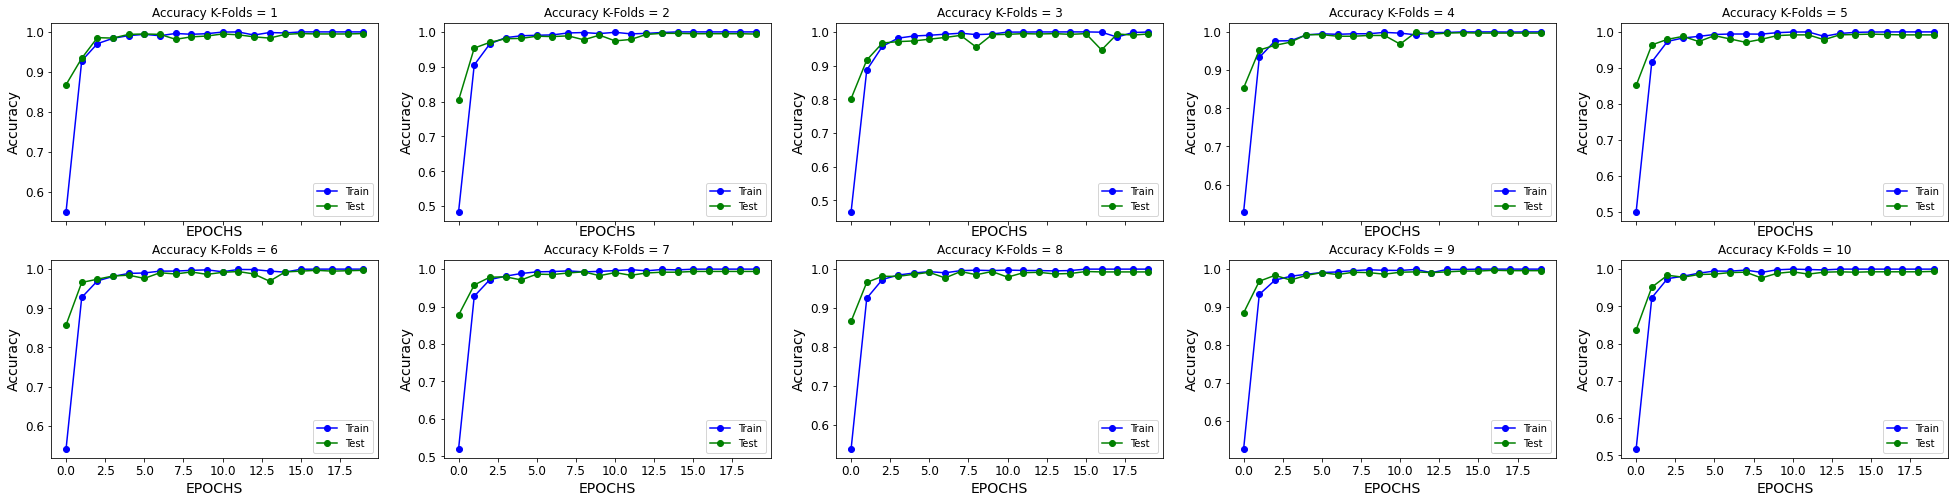

In [91]:
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(34,8))
for ax, _fold_counter in zip(axes.flatten(), kfolds_hist):
    ax.plot(kfolds_hist[_fold_counter].history['accuracy'], marker='o',label='Train', color='blue')
    ax.plot(kfolds_hist[_fold_counter].history['val_accuracy'], marker='o', label='Test', color='green')
    ax.set_title('Accuracy K-Folds = '+str(_fold_counter))
    ax.set(xlabel='EPOCHS', ylabel='Accuracy')
    ax.legend(loc='lower right')

#### Loss Plot

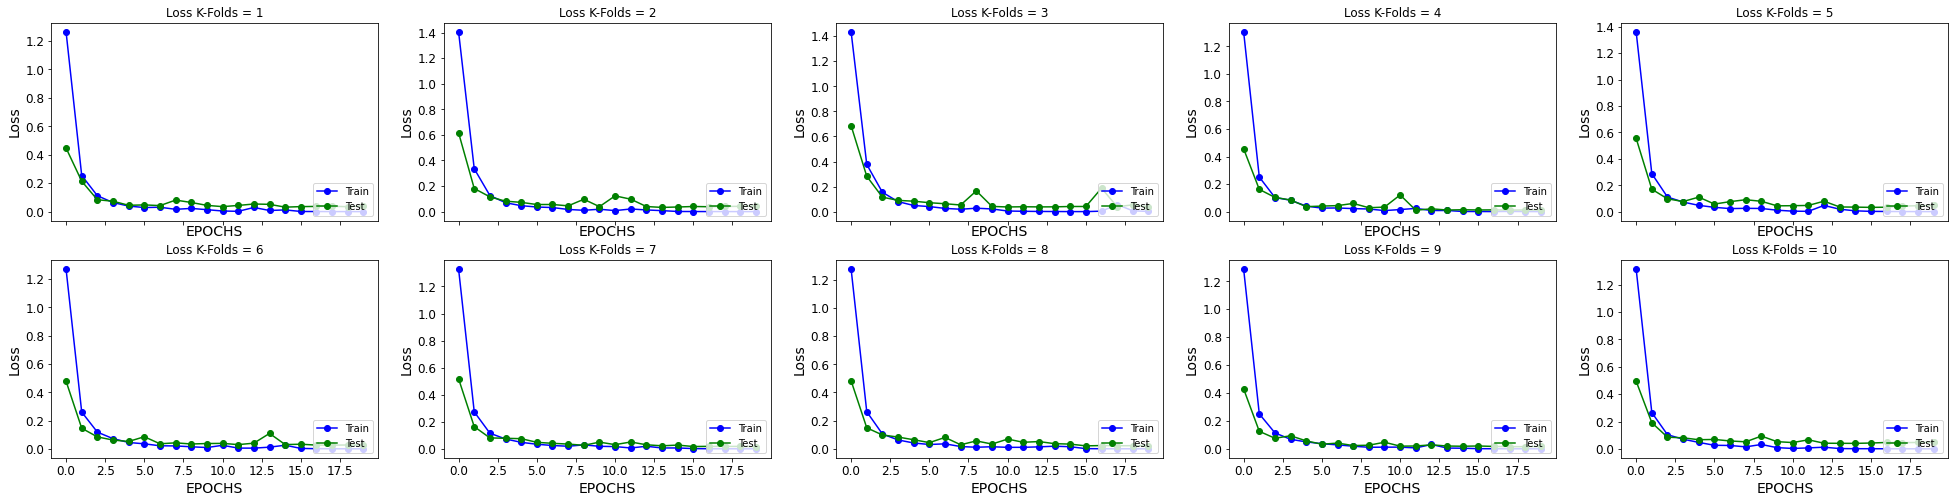

In [92]:
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(34,8))
for ax, _fold_counter in zip(axes.flatten(), kfolds_hist):
    ax.plot(kfolds_hist[_fold_counter].history['loss'], marker='o',label='Train', color='blue')
    ax.plot(kfolds_hist[_fold_counter].history['val_loss'], marker='o', label='Test', color='green')
    ax.set_title('Loss K-Folds = '+str(_fold_counter))
    ax.set(xlabel='EPOCHS', ylabel='Loss')
    ax.legend(loc='lower right')

#### Mean Squared Error Plot

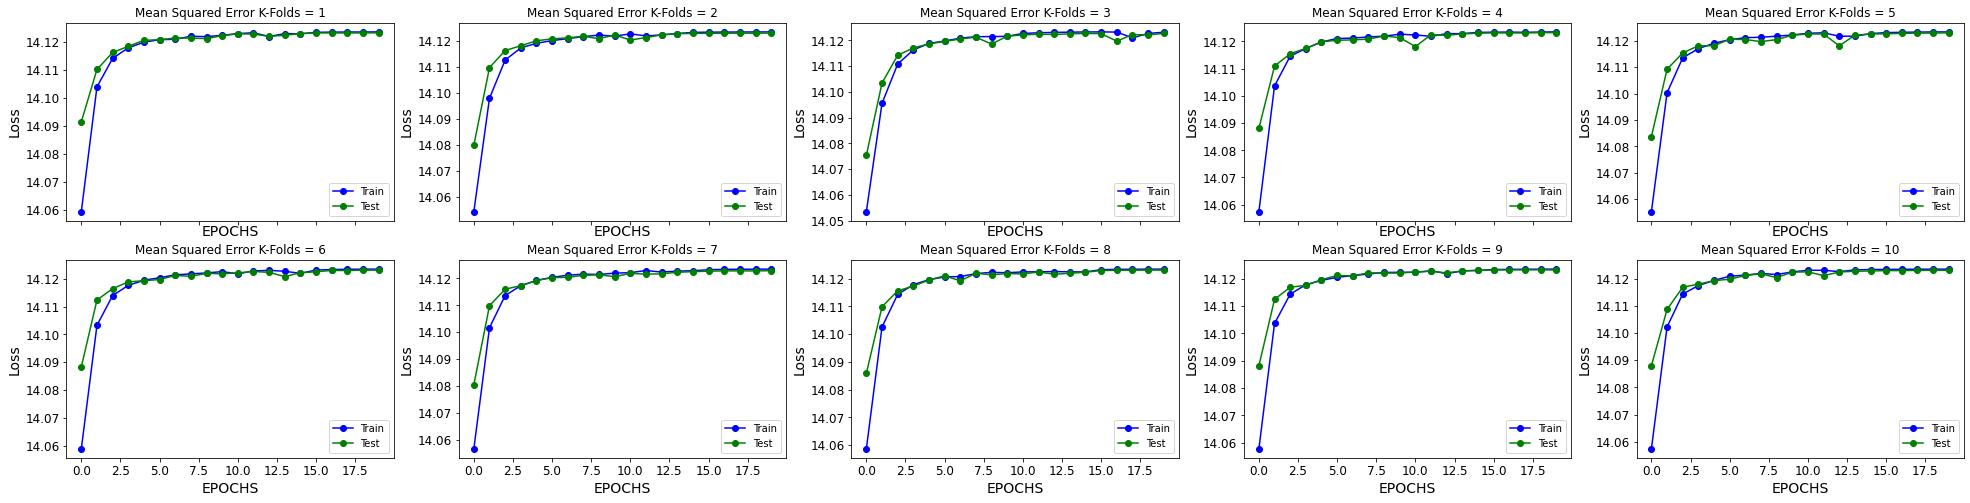

In [93]:
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(34,8))
for ax, _fold_counter in zip(axes.flatten(), kfolds_hist):
    ax.plot(kfolds_hist[_fold_counter].history['mean_squared_error'], marker='o',label='Train', color='blue')
    ax.plot(kfolds_hist[_fold_counter].history['val_mean_squared_error'], marker='o', label='Test', color='green')
    ax.set_title('Mean Squared Error K-Folds = '+str(_fold_counter))
    ax.set(xlabel='EPOCHS', ylabel='Loss')
    ax.legend(loc='lower right')

### Classification Report K-10 with ROC

In [94]:
np_roc = []
for key, value in kfolds_roc.items():
    kfolds_roc[key]['accuracy']=''
    kfolds_roc[key]['macro avg']=''
    kfolds_roc[key]['weighted avg']=''

for key, value in kfolds_roc.items():
    for i_k, i_v in value.items():
        np_roc.append(i_v)

In [95]:
df_folds_cl_rep = pd.DataFrame()
for folds in range(len(kfolds_cr)):
    df_folds_cl_rep = df_folds_cl_rep.append(pd.DataFrame(kfolds_cr[folds]).transpose(),ignore_index=False)
df_folds_cl_rep.loc['accuracy','precision']=''
df_folds_cl_rep.loc['accuracy','recall']=''
df_folds_cl_rep.loc['accuracy','folds']= np.NAN
df_folds_cl_rep = df_folds_cl_rep.fillna(method='ffill')
df_folds_cl_rep['roc_auc_score']=np_roc

In [96]:
df_folds_cl_rep

,precision,recall,f1-score,support,folds,roc_auc_score
0,1,1,1.000000,21.000000,1.0,1
1,0.995475,0.990991,0.993228,222.000000,1.0,0.994826
2,0.991189,1,0.995575,225.000000,1.0,0.998656
3,1,0.992908,0.996441,141.000000,1.0,0.996454
4,1,1,1.000000,198.000000,1.0,1
5,0.954545,1,0.976744,21.000000,1.0,0.999473
6,1,0.972222,0.985915,36.000000,1.0,0.986111
7,1,1,1.000000,24.000000,1.0,1
8,1,1,1.000000,54.000000,1.0,1
9,1,1,1.000000,27.000000,1.0,1


### ROC AUC Score Plot

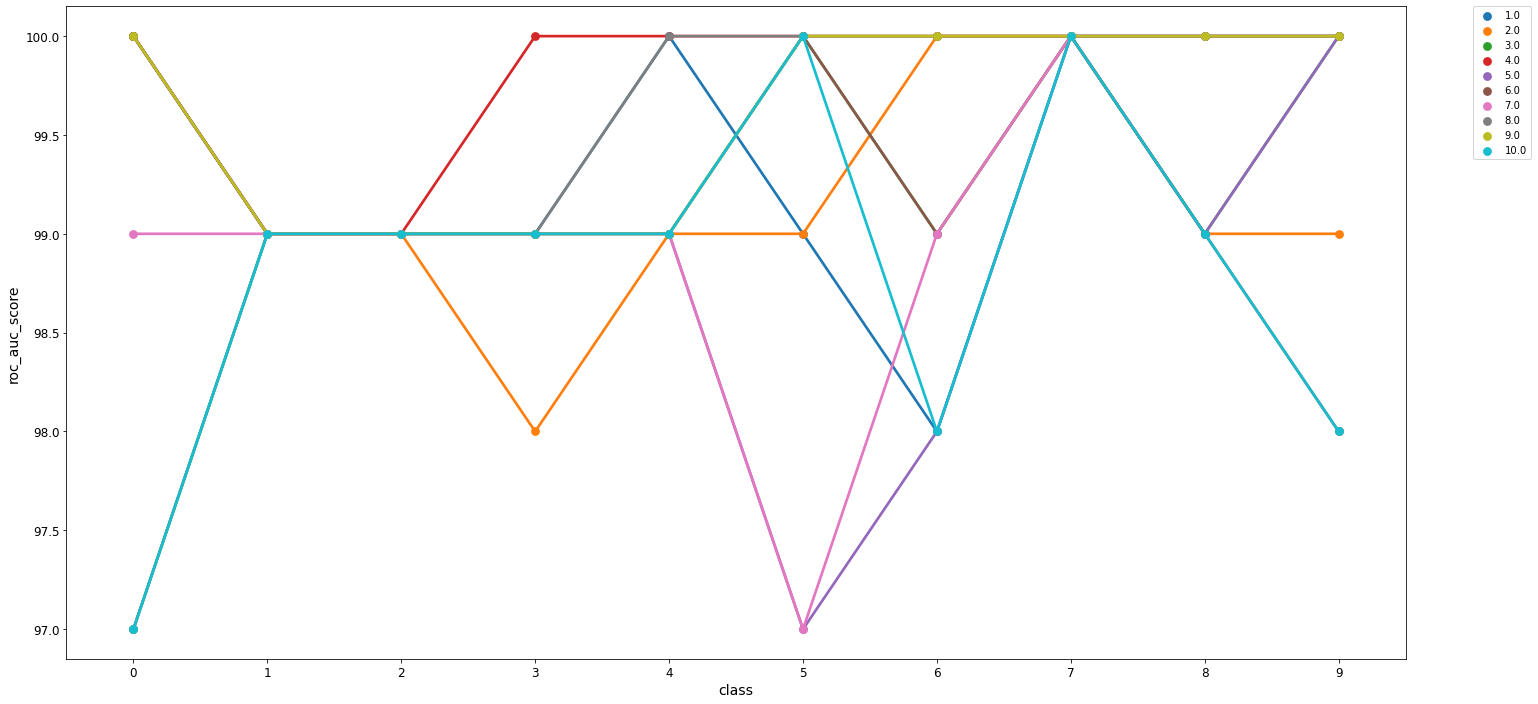

In [97]:
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(figsize=(24,12))
_data = df_folds_cl_rep[df_folds_cl_rep.roc_auc_score!='']
_data.loc[:,'roc_auc_score'] = _data.loc[:,'roc_auc_score'].apply(lambda x:x*100).astype(int)
_data = _data.reset_index()
_data.rename(columns={'index':'class'}, inplace=True)
palette = sns.color_palette("bright", 10)
ax = sns.pointplot(data=_data, x="class", y="roc_auc_score", hue='folds', marker='o', legend='full', palette='tab10', linewidth='2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Confusion Matrix K-10

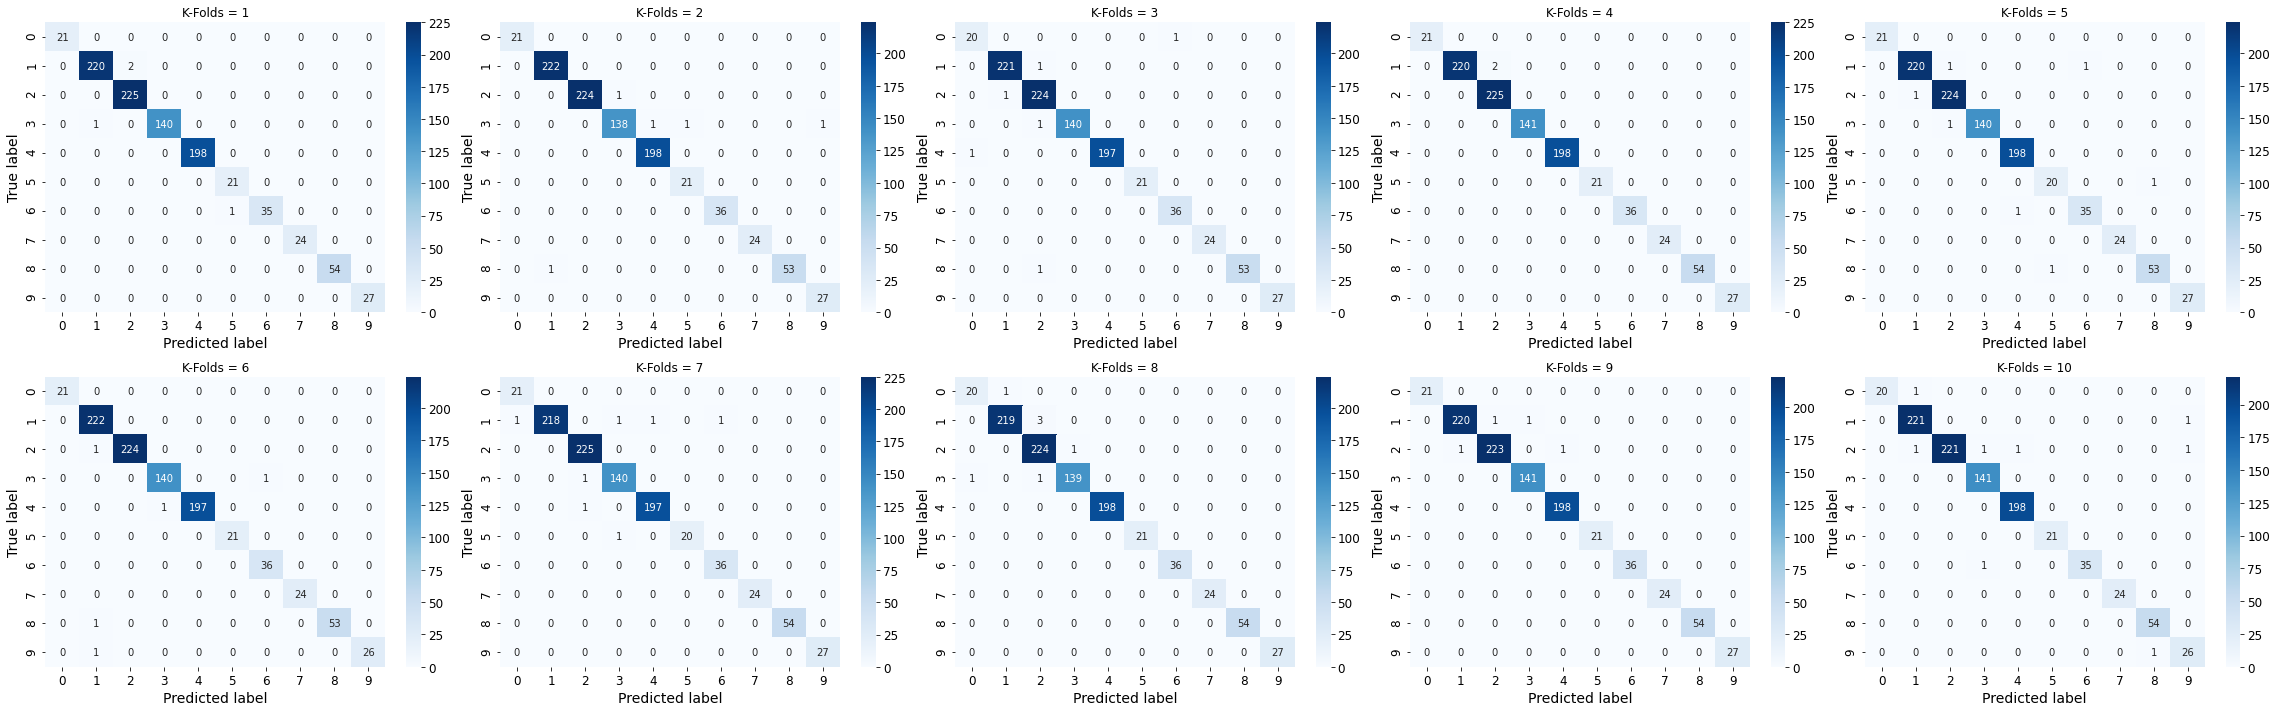

In [98]:
fig, axes = plt.subplots(2,5,figsize=(32,10))
for _fold_counter in range(len(kfolds_cm)):
    row = _fold_counter // 5
    col = _fold_counter % 5
    ax_curr = axes[row, col]
    sns.heatmap(kfolds_cm[_fold_counter], annot=True, cmap=plt.cm.Blues, fmt='g', ax=ax_curr)
    _chart_title = 'K-Folds = '+str(_fold_counter+1)
    ax_curr.set_title(_chart_title)
    ax_curr.set(xlabel='Predicted label', ylabel='True label')
    plt.tight_layout()
#     plt.show()

### Cross Validation Scores

In [99]:
df_folds_cvs = pd.DataFrame(kfolds_cvs)
df_folds_cvs.columns = ['cross_validation_score']
df_folds_cvs['k_folds'] = np.array(range(NO_OF_KFOLDS))
df_folds_cvs['epochs'] = NO_OF_EPOCHS
df_folds_cvs.sort_values(by=['cross_validation_score'], ascending=False)

,cross_validation_score,k_folds,epochs
3,99.793601,3,20
0,99.587202,0,20
8,99.587202,8,20
1,99.484003,1,20
5,99.484003,5,20
2,99.380803,2,20
4,99.277604,4,20
6,99.277604,6,20
7,99.277604,7,20
9,99.174404,9,20


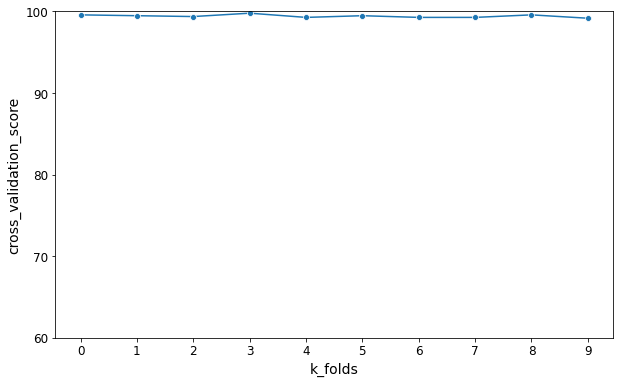

In [100]:
fig, axes = plt.subplots(figsize=(10,6))
ax = sns.lineplot(data=df_folds_cvs, x="k_folds", y="cross_validation_score", marker='o')
ax.set(xticks=df_folds_cvs.k_folds.values)
ax.set(yticks=np.arange(6,11)*10)
plt.show()

In [101]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(kfolds_cvs), np.std(kfolds_cvs)))

99.43% (+/- 0.18%)


## Question No. 3

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)
print('X_train', X_train.shape, 'X_test', X_test.shape, 'y_train', y_train.shape, 'y_test', y_test.shape)
X_train = X_train.to_numpy().reshape(X_train.shape[0],IMAGE_RESAMPLE,IMAGE_RESAMPLE,1)
X_test = X_test.to_numpy().reshape(X_test.shape[0],IMAGE_RESAMPLE,IMAGE_RESAMPLE,1)
print('X_train', X_train.shape, 'X_test', X_test.shape, 'y_train', y_train.shape, 'y_test', y_test.shape)

X_train (7752, 784) X_test (1938, 784) y_train (7752, 1) y_test (1938, 1)
X_train (7752, 28, 28, 1) X_test (1938, 28, 28, 1) y_train (7752, 1) y_test (1938, 1)


### Model Evaluation

In [103]:
if os.path.exists("logs/fit/seq/") : shutil.rmtree("logs/fit/seq/")
_model_cnn = f_createCNNModel()
_model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = _model_cnn.fit(X_train, y_train, epochs=NO_OF_EPOCHS, validation_data=(X_test, y_test))
log_dir = "logs/fit/seq/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es_callback = EarlyStopping(monitor='loss', patience=3) # This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs
_model_cnn.fit(x=X_train, 
              y=y_train, 
              epochs=NO_OF_EPOCHS, 
              verbose=0, # Suppress chatty output
              callbacks=[tensorboard_callback,es_callback],
              validation_data=(X_test, y_test),
             )
test_loss, test_acc = _model_cnn.evaluate(X_test,  y_test, verbose=0)
print('\nTest accuracy:', test_acc)
# %reload_ext tensorboard
# %tensorboard --logdir logs/fit/seq/
# Launch http://localhost:6006/

Epoch 1/20
243/243 [==============================] - 8s 32ms/step - loss: 1.5067 - accuracy: 0.4441 - val_loss: 0.8348 - val_accuracy: 0.7183
Epoch 2/20
243/243 [==============================] - 7s 29ms/step - loss: 0.4481 - accuracy: 0.8686 - val_loss: 0.2649 - val_accuracy: 0.9283
Epoch 3/20
243/243 [==============================] - 7s 29ms/step - loss: 0.1851 - accuracy: 0.9493 - val_loss: 0.1555 - val_accuracy: 0.9639
Epoch 4/20
243/243 [==============================] - 7s 28ms/step - loss: 0.1100 - accuracy: 0.9710 - val_loss: 0.1124 - val_accuracy: 0.9747
Epoch 5/20
243/243 [==============================] - 7s 29ms/step - loss: 0.0696 - accuracy: 0.9835 - val_loss: 0.1046 - val_accuracy: 0.9721
Epoch 6/20
243/243 [==============================] - 7s 28ms/step - loss: 0.0484 - accuracy: 0.9875 - val_loss: 0.1096 - val_accuracy: 0.9737
Epoch 7/20
243/243 [==============================] - 7s 29ms/step - loss: 0.0460 - accuracy: 0.9870 - val_loss: 0.0731 - val_accuracy: 0.9830

#### Bad Predictions

In [104]:
y_pred_train = _model_cnn.predict(X.to_numpy().reshape(X.shape[0],IMAGE_RESAMPLE,IMAGE_RESAMPLE,1))
bad_predictions = (y_pred_train.argmax(axis=1) != y.to_numpy().ravel())
print('Total bad predictions are', sum(bad_predictions))

Total bad predictions are 9


#### Accurancy and Loss Plot

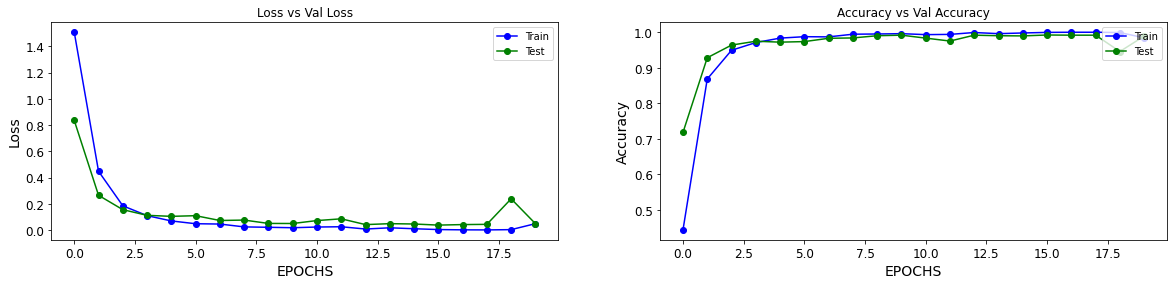

In [105]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,4))
ax1.plot(history.history['loss'], marker='o', label='Train', color='b')
ax1.plot(history.history['val_loss'], marker='o', label='Test', color='g')
ax1.set_title('Loss vs Val Loss')
ax1.set(xlabel='EPOCHS', ylabel='Loss')
ax1.legend(loc='upper right')
ax2.plot(history.history['accuracy'], marker='o', label='Train', color='b')
ax2.plot(history.history['val_accuracy'], marker='o', label='Test', color='g')
ax2.set_title('Accuracy vs Val Accuracy')
ax2.set(xlabel='EPOCHS', ylabel='Accuracy')
ax2.legend(loc='upper right')

### Predictions

In [106]:
y_predict = _model_cnn.predict(X_test)
y_pred_class = np.argmax(_model_cnn.predict(X_test), axis=-1) #predict_classes is depereciated

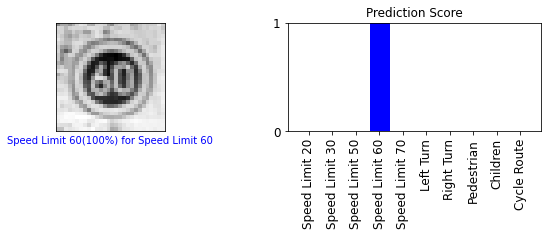

In [107]:
PREDICT_RECORD=15
f_PlotPresentPredictions(PREDICT_RECORD, y_predict[PREDICT_RECORD], y_test, X_test)

### Classification Report

In [108]:
roc_auc_score = f_ROC_AUC_Score_Multiclass(y_test.to_numpy().ravel(),y_pred_class)

In [109]:
roc_auc_score['accuracy']=''
roc_auc_score['macro avg']=''
roc_auc_score['weighted avg']=''
np_roc = []
for key, value in roc_auc_score.items():
    np_roc.append(value)

In [110]:
_classification_report = sklearn.metrics.classification_report(y_test, y_pred_class, output_dict=True)
df_seq_cr = pd.DataFrame(_classification_report).transpose()
df_seq_cr.loc['accuracy','precision']=''
df_seq_cr.loc['accuracy','recall']=''
df_seq_cr['roc_auc_score'] = np_roc
df_seq_cr

,precision,recall,f1-score,support,roc_auc_score
0,1,1,1.000000,41.000000,1
1,0.997701,0.993135,0.995413,437.000000,0.996234
2,0.995485,0.997738,0.996610,442.000000,0.9982
3,0.992537,0.996255,0.994393,267.000000,0.997529
4,0.995249,0.997619,0.996433,420.000000,0.998151
5,1,0.952381,0.975610,42.000000,0.97619
6,1,0.986667,0.993289,75.000000,0.993333
7,1,1,1.000000,50.000000,1
8,0.981982,1,0.990909,109.000000,0.999453
9,1,1,1.000000,55.000000,1


In [111]:
df_seq_cr.reset_index(inplace=True)
df_seq_cr = df_seq_cr.rename(columns = {'index':'Measure','f1-score':'f1_score'})
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='0', class_names[0], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='1', class_names[1], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='2', class_names[2], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='3', class_names[3], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='4', class_names[4], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='5', class_names[5], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='6', class_names[6], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='7', class_names[7], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='8', class_names[8], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='9', class_names[9], df_seq_cr['Measure'])
df_seq_cr

,Measure,precision,recall,f1_score,support,roc_auc_score
0,Speed Limit 20,1,1,1.000000,41.000000,1
1,Speed Limit 30,0.997701,0.993135,0.995413,437.000000,0.996234
2,Speed Limit 50,0.995485,0.997738,0.996610,442.000000,0.9982
3,Speed Limit 60,0.992537,0.996255,0.994393,267.000000,0.997529
4,Speed Limit 70,0.995249,0.997619,0.996433,420.000000,0.998151
5,Left Turn,1,0.952381,0.975610,42.000000,0.97619
6,Right Turn,1,0.986667,0.993289,75.000000,0.993333
7,Pedestrian,1,1,1.000000,50.000000,1
8,Children,0.981982,1,0.990909,109.000000,0.999453
9,Cycle Route,1,1,1.000000,55.000000,1


### ROC AUC Score Plot

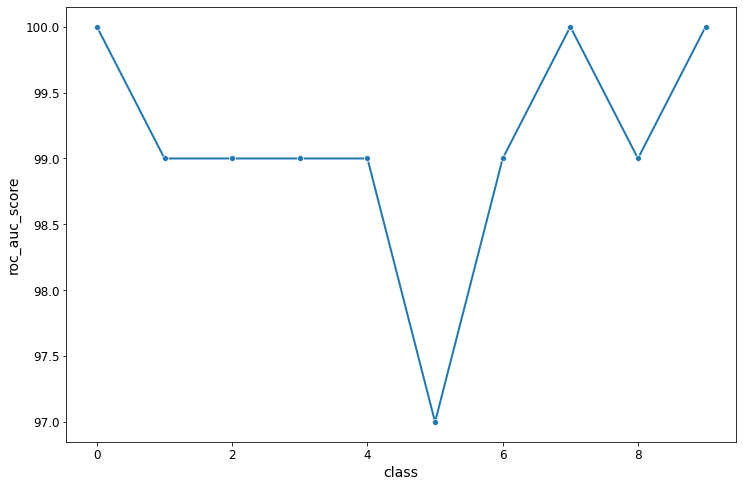

In [112]:
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(figsize=(12,8))
_data = df_seq_cr[df_seq_cr.roc_auc_score!='']
_data.loc[:,'roc_auc_score'] = _data.loc[:,'roc_auc_score'].apply(lambda x:x*100).astype(int)
_data = _data.reset_index()
_data.rename(columns={'index':'class'}, inplace=True)
palette = sns.color_palette("bright", 10)
ax = sns.lineplot(data=_data, x="class", y="roc_auc_score",  marker='o', palette='tab10', linewidth='2')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Confusion Matrix

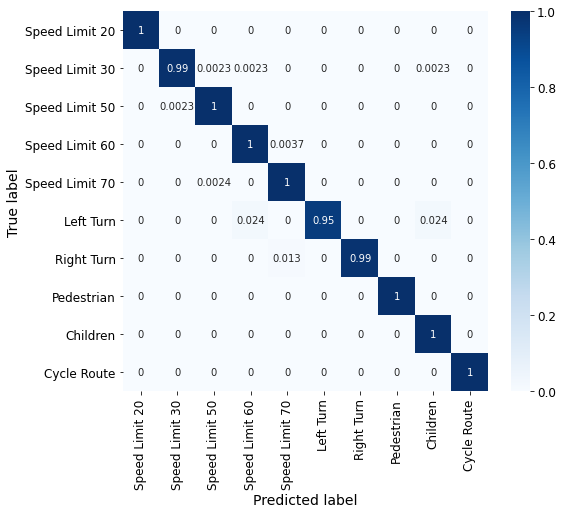

In [113]:
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred_class).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=5)
con_mat_df = pd.DataFrame(con_mat_norm,index = class_names, columns = class_names)
con_mat_df
figure = plt.figure(figsize=(8, 7))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### TP, TN, FP, FN

In [114]:
df_seq_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, y_pred_class))
df_seq_cm.columns=class_names
df_seq_cm.index = class_names
df_seq_cm

,Speed Limit 20,Speed Limit 30,Speed Limit 50,Speed Limit 60,Speed Limit 70,Left Turn,Right Turn,Pedestrian,Children,Cycle Route
Speed Limit 20,41,0,0,0,0,0,0,0,0,0
Speed Limit 30,0,434,1,1,0,0,0,0,1,0
Speed Limit 50,0,1,441,0,0,0,0,0,0,0
Speed Limit 60,0,0,0,266,1,0,0,0,0,0
Speed Limit 70,0,0,1,0,419,0,0,0,0,0
Left Turn,0,0,0,1,0,40,0,0,1,0
Right Turn,0,0,0,0,1,0,74,0,0,0
Pedestrian,0,0,0,0,0,0,0,50,0,0
Children,0,0,0,0,0,0,0,0,109,0
Cycle Route,0,0,0,0,0,0,0,0,0,55


<AxesSubplot:title={'center':'Confusion Matrix (TP, TN, FP, FN)'}>

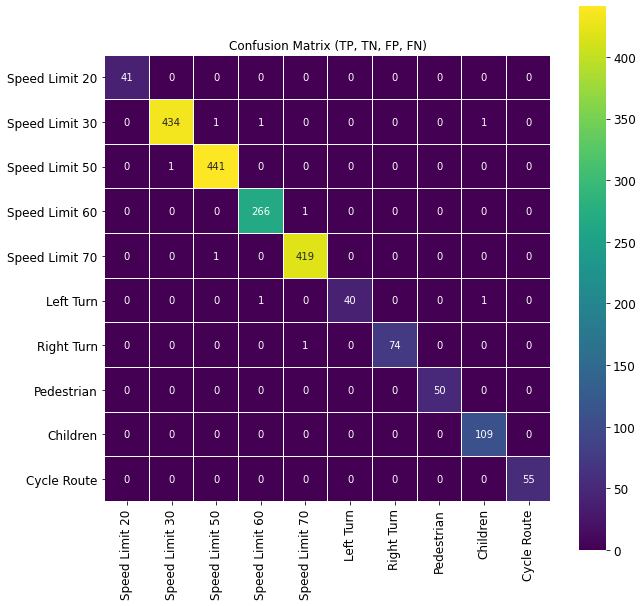

In [115]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Confusion Matrix (TP, TN, FP, FN)')
sns.heatmap(df_seq_cm, 
            cmap="viridis",
            fmt=".0f",
            annot_kws={"fontsize":10},
            square=True,
            annot=True,
           linewidths=.01,
           ax=ax)

### Grid Search

In [116]:
model = KerasClassifier(build_fn=f_CNNModelGridSearch, verbose=0)
optimizers = ['adam']
init = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(epochs=GS_EPOCHS, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=5, return_train_score=False, n_jobs=-1, cv=None)

In [117]:
grid_result = grid.fit(XX, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 106.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 196.2min finished


In [118]:
gr_results = grid_result.cv_results_

In [119]:
scores_df = pd.DataFrame(gr_results).sort_values(by=['param_epochs','param_init'])
scores_df = scores_df.drop(['params'], axis=1)
scores_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_epochs,param_init,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,43.634442,5.030033,7.534470,4.629631,1,glorot_normal,0.294634,0.590299,0.386997,0.164087,0.139835,0.315170,0.164223,31
5,41.476449,2.462843,5.343458,1.745329,1,glorot_uniform,0.603199,0.483488,0.447884,0.389061,0.144479,0.413622,0.151681,29
6,41.362227,6.089151,7.162811,2.569717,1,he_normal,0.185759,0.390609,0.420537,0.107327,0.146543,0.250155,0.129645,33
7,44.997339,5.955187,7.660320,2.202857,1,he_uniform,0.514964,0.452528,0.360681,0.336945,0.143963,0.361816,0.126303,30
1,42.467759,2.564527,5.151264,1.929451,1,lecun_uniform,0.238906,0.585139,0.220846,0.137771,0.079463,0.252425,0.176034,32
2,44.041261,2.837181,4.436562,1.731017,1,normal,0.250774,0.273478,0.372033,0.123839,0.076367,0.219298,0.106579,34
0,44.211628,0.727089,3.494297,0.236989,1,uniform,0.000000,0.302374,0.074303,0.097007,0.083075,0.111352,0.101259,35
3,38.679393,3.301637,7.271077,1.894956,1,zero,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36
12,228.997624,7.118835,10.669318,2.914329,5,glorot_normal,0.748710,0.834881,0.905057,0.678535,0.164087,0.666254,0.262520,25
13,224.952170,3.655861,9.984215,3.677117,5,glorot_uniform,0.671311,0.894737,0.939112,0.727038,0.162539,0.678947,0.276875,21


In [120]:
print('Optimal Combination',grid_result.best_params_)

Optimal Combination {'epochs': 20, 'init': 'he_normal'}


## Question No. 4

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.60, random_state=RANDOM_STATE)
print('X_train', X_train.shape, 'X_test', X_test.shape, 'y_train', y_train.shape, 'y_test', y_test.shape)
X_train = X_train.to_numpy().reshape(X_train.shape[0],IMAGE_RESAMPLE,IMAGE_RESAMPLE,1)
X_test = X_test.to_numpy().reshape(X_test.shape[0],IMAGE_RESAMPLE,IMAGE_RESAMPLE,1)
print('X_train', X_train.shape, 'X_test', X_test.shape, 'y_train', y_train.shape, 'y_test', y_test.shape)

X_train (3876, 784) X_test (5814, 784) y_train (3876, 1) y_test (5814, 1)
X_train (3876, 28, 28, 1) X_test (5814, 28, 28, 1) y_train (3876, 1) y_test (5814, 1)


### Model Evaluation

In [122]:
if os.path.exists("logs/fit/seq/") : shutil.rmtree("logs/fit/seq/")
_model_cnn = f_createCNNModel()
_model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = _model_cnn.fit(X_train, y_train, epochs=NO_OF_EPOCHS, validation_data=(X_test, y_test))

log_dir = "logs/fit/seq/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es_callback = EarlyStopping(monitor='loss', patience=3) # This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs
_model_cnn.fit(x=X_train, 
              y=y_train, 
              epochs=NO_OF_EPOCHS, 
              verbose=0, # Suppress chatty output
              callbacks=[tensorboard_callback,es_callback],
              validation_data=(X_test, y_test),
             )
test_loss, test_acc = _model_cnn.evaluate(X_test,  y_test, verbose=0)
print('\nTest accuracy:', test_acc)
# %reload_ext tensorboard
# %tensorboard --logdir logs/fit/seq/
# Launch http://localhost:6006/

Epoch 1/20
122/122 [==============================] - 6s 48ms/step - loss: 1.8099 - accuracy: 0.3308 - val_loss: 1.6204 - val_accuracy: 0.3901
Epoch 2/20
122/122 [==============================] - 5s 44ms/step - loss: 1.2984 - accuracy: 0.5307 - val_loss: 0.8802 - val_accuracy: 0.7078
Epoch 3/20
122/122 [==============================] - 5s 40ms/step - loss: 0.5981 - accuracy: 0.8230 - val_loss: 0.4255 - val_accuracy: 0.8626
Epoch 4/20
122/122 [==============================] - 5s 39ms/step - loss: 0.3003 - accuracy: 0.9190 - val_loss: 0.2367 - val_accuracy: 0.9279
Epoch 5/20
122/122 [==============================] - 5s 42ms/step - loss: 0.1790 - accuracy: 0.9538 - val_loss: 0.1729 - val_accuracy: 0.9515
Epoch 6/20
122/122 [==============================] - 5s 41ms/step - loss: 0.1281 - accuracy: 0.9680 - val_loss: 0.1499 - val_accuracy: 0.9561
Epoch 7/20
122/122 [==============================] - 5s 41ms/step - loss: 0.0911 - accuracy: 0.9788 - val_loss: 0.1166 - val_accuracy: 0.9668

#### Bad Predictions

In [123]:
y_pred_train = _model_cnn.predict(X.to_numpy().reshape(X.shape[0],IMAGE_RESAMPLE,IMAGE_RESAMPLE,1))
bad_predictions = (y_pred_train.argmax(axis=1) != y.to_numpy().ravel())
print('Total bad predictions are', sum(bad_predictions))

Total bad predictions are 106


#### Accurancy and Loss Plot

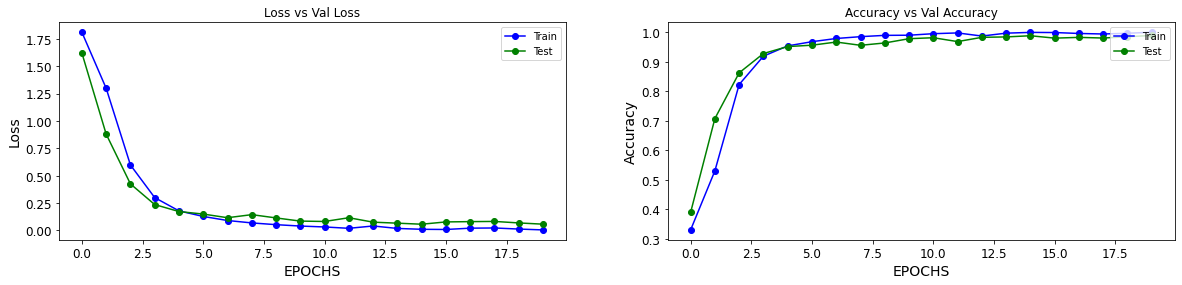

In [124]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,4))
ax1.plot(history.history['loss'], marker='o', label='Train', color='b')
ax1.plot(history.history['val_loss'], marker='o', label='Test', color='g')
ax1.set_title('Loss vs Val Loss')
ax1.set(xlabel='EPOCHS', ylabel='Loss')
ax1.legend(loc='upper right')
ax2.plot(history.history['accuracy'], marker='o', label='Train', color='b')
ax2.plot(history.history['val_accuracy'], marker='o', label='Test', color='g')
ax2.set_title('Accuracy vs Val Accuracy')
ax2.set(xlabel='EPOCHS', ylabel='Accuracy')
ax2.legend(loc='upper right')

### Predictions

In [125]:
y_predict = _model_cnn.predict(X_test)
y_pred_class = np.argmax(_model_cnn.predict(X_test), axis=-1) #predict_classes is depereciated

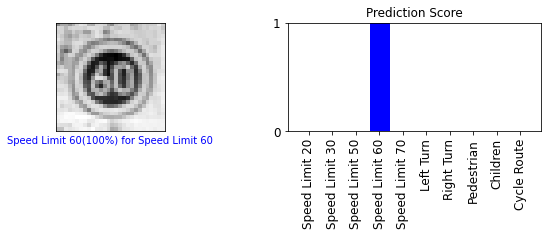

In [126]:
PREDICT_RECORD=15
f_PlotPresentPredictions(PREDICT_RECORD, y_predict[PREDICT_RECORD], y_test, X_test)

### Classification Report

In [127]:
roc_auc_score = f_ROC_AUC_Score_Multiclass(y_test.to_numpy().ravel(),y_pred_class)

In [128]:
roc_auc_score['accuracy']=''
roc_auc_score['macro avg']=''
roc_auc_score['weighted avg']=''
np_roc = []
for key, value in roc_auc_score.items():
    np_roc.append(value)

In [129]:
_classification_report = sklearn.metrics.classification_report(y_test, y_pred_class, output_dict=True)
df_seq_cr = pd.DataFrame(_classification_report).transpose()
df_seq_cr.loc['accuracy','precision']=''
df_seq_cr.loc['accuracy','recall']=''
df_seq_cr['roc_auc_score'] = np_roc
df_seq_cr

,precision,recall,f1-score,support,roc_auc_score
0,0.97561,0.967742,0.971660,124.000000,0.983607
1,0.978159,0.983529,0.980837,1275.000000,0.98868
2,0.982105,0.989899,0.985986,1386.000000,0.992127
3,0.996364,0.979738,0.987981,839.000000,0.989567
4,0.996689,0.99422,0.995453,1211.000000,0.996675
5,0.983193,0.983193,0.983193,119.000000,0.991421
6,0.93722,0.976636,0.956522,214.000000,0.987068
7,0.9625,0.993548,0.977778,155.000000,0.996244
8,0.984663,0.975684,0.980153,329.000000,0.987386
9,0.986755,0.919753,0.952077,162.000000,0.9597


In [130]:
df_seq_cr.reset_index(inplace=True)
df_seq_cr = df_seq_cr.rename(columns = {'index':'Measure','f1-score':'f1_score'})
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='0', class_names[0], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='1', class_names[1], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='2', class_names[2], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='3', class_names[3], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='4', class_names[4], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='5', class_names[5], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='6', class_names[6], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='7', class_names[7], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='8', class_names[8], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='9', class_names[9], df_seq_cr['Measure'])
df_seq_cr

,Measure,precision,recall,f1_score,support,roc_auc_score
0,Speed Limit 20,0.97561,0.967742,0.971660,124.000000,0.983607
1,Speed Limit 30,0.978159,0.983529,0.980837,1275.000000,0.98868
2,Speed Limit 50,0.982105,0.989899,0.985986,1386.000000,0.992127
3,Speed Limit 60,0.996364,0.979738,0.987981,839.000000,0.989567
4,Speed Limit 70,0.996689,0.99422,0.995453,1211.000000,0.996675
5,Left Turn,0.983193,0.983193,0.983193,119.000000,0.991421
6,Right Turn,0.93722,0.976636,0.956522,214.000000,0.987068
7,Pedestrian,0.9625,0.993548,0.977778,155.000000,0.996244
8,Children,0.984663,0.975684,0.980153,329.000000,0.987386
9,Cycle Route,0.986755,0.919753,0.952077,162.000000,0.9597


### ROC AUC Score Plot

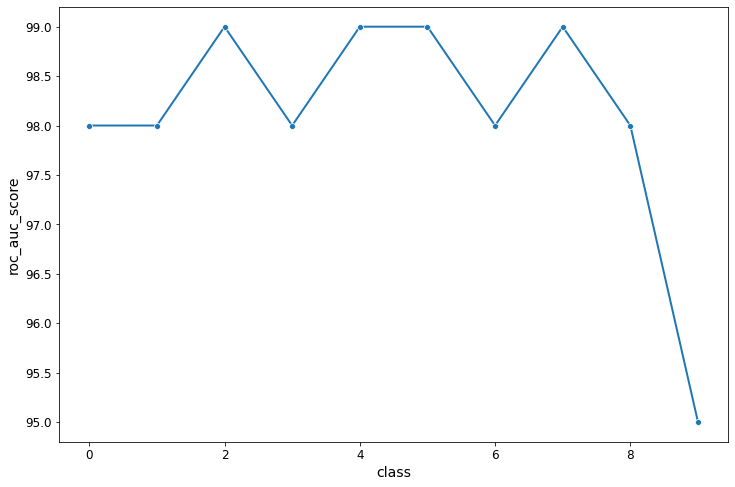

In [131]:
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(figsize=(12,8))
_data = df_seq_cr[df_seq_cr.roc_auc_score!='']
_data.loc[:,'roc_auc_score'] = _data.loc[:,'roc_auc_score'].apply(lambda x:x*100).astype(int)
_data = _data.reset_index()
_data.rename(columns={'index':'class'}, inplace=True)
palette = sns.color_palette("bright", 10)
ax = sns.lineplot(data=_data, x="class", y="roc_auc_score",  marker='o', palette='tab10', linewidth='2')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Confusion Matrix

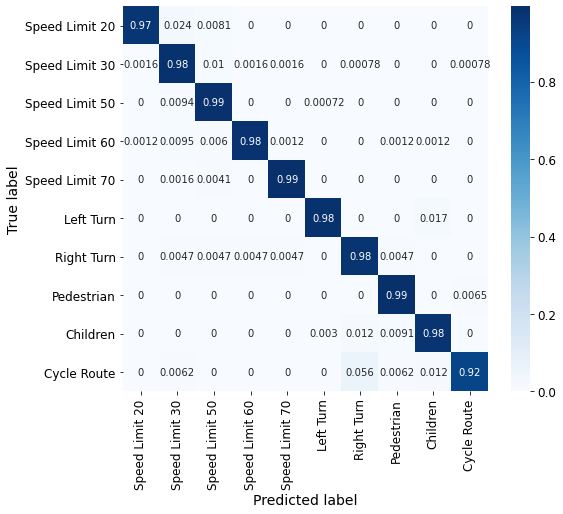

In [132]:
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred_class).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=5)
con_mat_df = pd.DataFrame(con_mat_norm,index = class_names, columns = class_names)
con_mat_df
figure = plt.figure(figsize=(8, 7))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### TP, TN, FP, FN

In [133]:
df_seq_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, y_pred_class))
df_seq_cm.columns=class_names
df_seq_cm.index = class_names
df_seq_cm

,Speed Limit 20,Speed Limit 30,Speed Limit 50,Speed Limit 60,Speed Limit 70,Left Turn,Right Turn,Pedestrian,Children,Cycle Route
Speed Limit 20,120,3,1,0,0,0,0,0,0,0
Speed Limit 30,2,1254,13,2,2,0,1,0,0,1
Speed Limit 50,0,13,1372,0,0,1,0,0,0,0
Speed Limit 60,1,8,5,822,1,0,0,1,1,0
Speed Limit 70,0,2,5,0,1204,0,0,0,0,0
Left Turn,0,0,0,0,0,117,0,0,2,0
Right Turn,0,1,1,1,1,0,209,1,0,0
Pedestrian,0,0,0,0,0,0,0,154,0,1
Children,0,0,0,0,0,1,4,3,321,0
Cycle Route,0,1,0,0,0,0,9,1,2,149


<AxesSubplot:title={'center':'Confusion Matrix (TP, TN, FP, FN)'}>

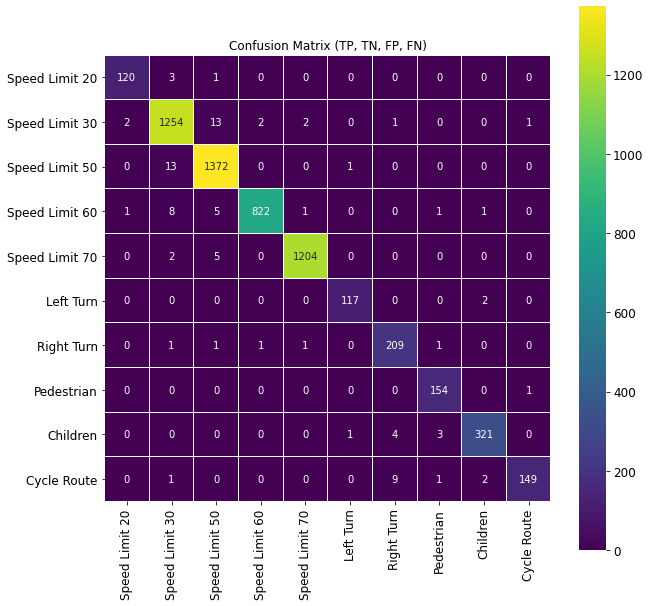

In [134]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Confusion Matrix (TP, TN, FP, FN)')
sns.heatmap(df_seq_cm, 
            cmap="viridis",
            fmt=".0f",
            annot_kws={"fontsize":10},
            square=True,
            annot=True,
           linewidths=.01,
           ax=ax)

### Grid Search

In [135]:
model = KerasClassifier(build_fn=f_CNNModelGridSearch, verbose=0)
optimizers = ['adam']
init = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(epochs=GS_EPOCHS, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=5, return_train_score=False, n_jobs=-1, cv=None)

In [136]:
grid_result = grid.fit(XX, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 107.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 196.3min finished


In [137]:
gr_results = grid_result.cv_results_

In [138]:
scores_df = pd.DataFrame(gr_results).sort_values(by=['param_epochs','param_init'])
scores_df = scores_df.drop(['params'], axis=1)
scores_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_epochs,param_init,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,46.616025,4.272906,5.118368,1.619732,1,glorot_normal,0.621775,0.509804,0.350361,0.153251,0.123839,0.351806,0.194547,31
5,41.281594,3.933981,6.455625,1.214841,1,glorot_uniform,0.539732,0.536636,0.291022,0.081011,0.133643,0.316409,0.193821,33
6,46.910063,4.491290,6.792309,1.976153,1,he_normal,0.330237,0.510320,0.490196,0.442724,0.141383,0.382972,0.135964,29
7,45.883877,1.696809,8.289644,2.233875,1,he_uniform,0.518060,0.486584,0.405057,0.137771,0.100619,0.329618,0.176117,32
1,42.563709,1.365171,4.333494,1.781238,1,lecun_uniform,0.597523,0.577915,0.341073,0.147575,0.147575,0.362332,0.197223,30
2,43.072800,2.800430,4.415828,1.504755,1,normal,0.287410,0.297214,0.126419,0.218782,0.147575,0.215480,0.069869,34
0,44.269180,0.224766,3.124003,0.320957,1,uniform,0.201754,0.453044,0.123839,0.115067,0.111455,0.201032,0.130295,35
3,38.380245,4.444065,8.245873,3.163062,1,zero,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36
12,224.398827,2.448419,10.432557,1.450685,5,glorot_normal,0.836945,0.694014,0.846749,0.749226,0.163571,0.658101,0.253664,24
13,223.364105,5.515647,10.109214,0.497448,5,glorot_uniform,0.711042,0.883901,0.887513,0.729102,0.162539,0.674819,0.266700,22


In [139]:
print('Optimal Combination',grid_result.best_params_)

Optimal Combination {'epochs': 10, 'init': 'lecun_uniform'}


## Question No. 5

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.93, random_state=RANDOM_STATE)
print('X_train', X_train.shape, 'X_test', X_test.shape, 'y_train', y_train.shape, 'y_test', y_test.shape)
X_train = X_train.to_numpy().reshape(X_train.shape[0],IMAGE_RESAMPLE,IMAGE_RESAMPLE,1)
X_test = X_test.to_numpy().reshape(X_test.shape[0],IMAGE_RESAMPLE,IMAGE_RESAMPLE,1)
print('X_train', X_train.shape, 'X_test', X_test.shape, 'y_train', y_train.shape, 'y_test', y_test.shape)

X_train (678, 784) X_test (9012, 784) y_train (678, 1) y_test (9012, 1)
X_train (678, 28, 28, 1) X_test (9012, 28, 28, 1) y_train (678, 1) y_test (9012, 1)


### Model Evaluation

In [141]:
if os.path.exists("logs/fit/seq/") : shutil.rmtree("logs/fit/seq/")
_model_cnn = f_createCNNModel()
_model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = _model_cnn.fit(X_train, y_train, epochs=NO_OF_EPOCHS, validation_data=(X_test, y_test))
log_dir = "logs/fit/seq/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es_callback = EarlyStopping(monitor='loss', patience=3) # This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs
_model_cnn.fit(x=X_train, 
              y=y_train, 
              epochs=NO_OF_EPOCHS, 
              verbose=0, # Suppress chatty output
              callbacks=[tensorboard_callback,es_callback],
              validation_data=(X_test, y_test),
             )
test_loss, test_acc = _model_cnn.evaluate(X_test,  y_test, verbose=0)
print('\nTest accuracy:', test_acc)
# %reload_ext tensorboard
# %tensorboard --logdir logs/fit/seq/
# Launch http://localhost:6006/

Epoch 1/20
22/22 [==============================] - 4s 181ms/step - loss: 2.0372 - accuracy: 0.2670 - val_loss: 1.9161 - val_accuracy: 0.2640
Epoch 2/20
22/22 [==============================] - 3s 140ms/step - loss: 1.9210 - accuracy: 0.2979 - val_loss: 1.8195 - val_accuracy: 0.3048
Epoch 3/20
22/22 [==============================] - 3s 132ms/step - loss: 1.8073 - accuracy: 0.2891 - val_loss: 1.6583 - val_accuracy: 0.3380
Epoch 4/20
22/22 [==============================] - 3s 140ms/step - loss: 1.6516 - accuracy: 0.3643 - val_loss: 1.5205 - val_accuracy: 0.3865
Epoch 5/20
22/22 [==============================] - 3s 136ms/step - loss: 1.4701 - accuracy: 0.4528 - val_loss: 1.4213 - val_accuracy: 0.4494
Epoch 6/20
22/22 [==============================] - 3s 145ms/step - loss: 1.3113 - accuracy: 0.5044 - val_loss: 1.2681 - val_accuracy: 0.5092
Epoch 7/20
22/22 [==============================] - 3s 142ms/step - loss: 1.1104 - accuracy: 0.5929 - val_loss: 1.0549 - val_accuracy: 0.6310
Epoch 

#### Bad Predictions

In [142]:
y_pred_train = _model_cnn.predict(X.to_numpy().reshape(X.shape[0],IMAGE_RESAMPLE,IMAGE_RESAMPLE,1))
bad_predictions = (y_pred_train.argmax(axis=1) != y.to_numpy().ravel())
print('Total bad predictions are', sum(bad_predictions))

Total bad predictions are 717


#### Accurancy and Loss Plot

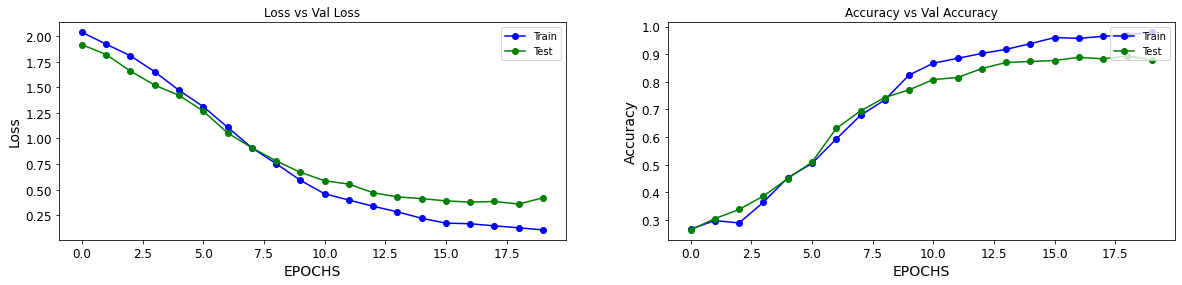

In [143]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,4))
ax1.plot(history.history['loss'], marker='o', label='Train', color='b')
ax1.plot(history.history['val_loss'], marker='o', label='Test', color='g')
ax1.set_title('Loss vs Val Loss')
ax1.set(xlabel='EPOCHS', ylabel='Loss')
ax1.legend(loc='upper right')
ax2.plot(history.history['accuracy'], marker='o', label='Train', color='b')
ax2.plot(history.history['val_accuracy'], marker='o', label='Test', color='g')
ax2.set_title('Accuracy vs Val Accuracy')
ax2.set(xlabel='EPOCHS', ylabel='Accuracy')
ax2.legend(loc='upper right')

### Predictions

In [144]:
y_predict = _model_cnn.predict(X_test)
y_pred_class = np.argmax(_model_cnn.predict(X_test), axis=-1) #predict_classes is depereciated

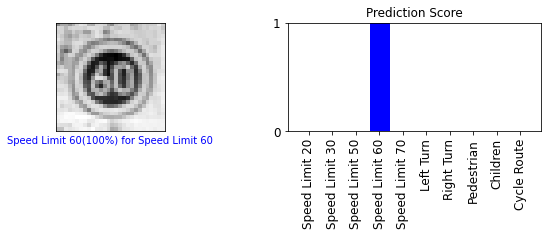

In [145]:
PREDICT_RECORD=15
f_PlotPresentPredictions(PREDICT_RECORD, y_predict[PREDICT_RECORD], y_test, X_test)

### Classification Report

In [146]:
roc_auc_score = f_ROC_AUC_Score_Multiclass(y_test.to_numpy().ravel(),y_pred_class)

In [147]:
roc_auc_score['accuracy']=''
roc_auc_score['macro avg']=''
roc_auc_score['weighted avg']=''
np_roc = []
for key, value in roc_auc_score.items():
    np_roc.append(value)

In [148]:
_classification_report = sklearn.metrics.classification_report(y_test, y_pred_class, output_dict=True)
df_seq_cr = pd.DataFrame(_classification_report).transpose()
df_seq_cr.loc['accuracy','precision']=''
df_seq_cr.loc['accuracy','recall']=''
df_seq_cr['roc_auc_score'] = np_roc
df_seq_cr

,precision,recall,f1-score,support,roc_auc_score
0,0.90991,0.528796,0.668874,191.000000,0.763831
1,0.922923,0.890821,0.906588,2070.000000,0.934319
2,0.901596,0.962612,0.931106,2113.000000,0.965217
3,0.977707,0.93384,0.955270,1315.000000,0.965101
4,0.918766,0.978642,0.947759,1826.000000,0.978327
5,0.926966,0.868421,0.896739,190.000000,0.933474
6,0.93038,0.877612,0.903226,335.000000,0.937538
7,0.973958,0.846154,0.905569,221.000000,0.922793
8,0.871893,0.913828,0.892368,499.000000,0.952979
9,0.839662,0.789683,0.813906,252.000000,0.892672


In [149]:
df_seq_cr.reset_index(inplace=True)
df_seq_cr = df_seq_cr.rename(columns = {'index':'Measure','f1-score':'f1_score'})
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='0', class_names[0], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='1', class_names[1], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='2', class_names[2], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='3', class_names[3], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='4', class_names[4], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='5', class_names[5], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='6', class_names[6], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='7', class_names[7], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='8', class_names[8], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='9', class_names[9], df_seq_cr['Measure'])
df_seq_cr

,Measure,precision,recall,f1_score,support,roc_auc_score
0,Speed Limit 20,0.90991,0.528796,0.668874,191.000000,0.763831
1,Speed Limit 30,0.922923,0.890821,0.906588,2070.000000,0.934319
2,Speed Limit 50,0.901596,0.962612,0.931106,2113.000000,0.965217
3,Speed Limit 60,0.977707,0.93384,0.955270,1315.000000,0.965101
4,Speed Limit 70,0.918766,0.978642,0.947759,1826.000000,0.978327
5,Left Turn,0.926966,0.868421,0.896739,190.000000,0.933474
6,Right Turn,0.93038,0.877612,0.903226,335.000000,0.937538
7,Pedestrian,0.973958,0.846154,0.905569,221.000000,0.922793
8,Children,0.871893,0.913828,0.892368,499.000000,0.952979
9,Cycle Route,0.839662,0.789683,0.813906,252.000000,0.892672


### ROC AUC Score Plot

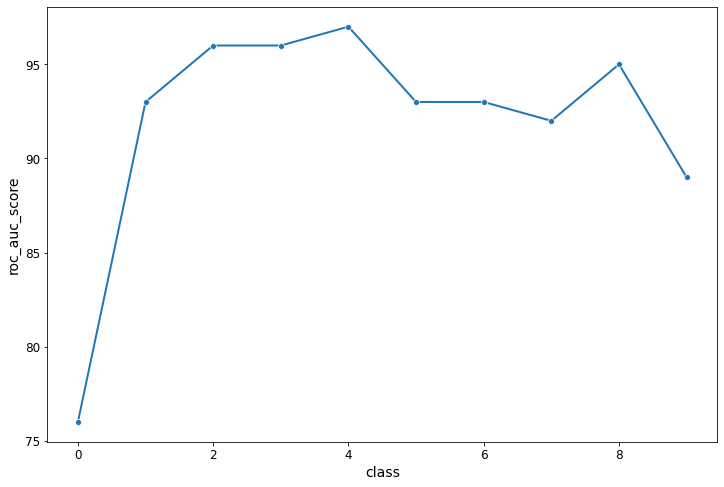

In [150]:
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(figsize=(12,8))
_data = df_seq_cr[df_seq_cr.roc_auc_score!='']
_data.loc[:,'roc_auc_score'] = _data.loc[:,'roc_auc_score'].apply(lambda x:x*100).astype(int)
_data = _data.reset_index()
_data.rename(columns={'index':'class'}, inplace=True)
palette = sns.color_palette("bright", 10)
ax = sns.lineplot(data=_data, x="class", y="roc_auc_score",  marker='o', palette='tab10', linewidth='2')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Confusion Matrix

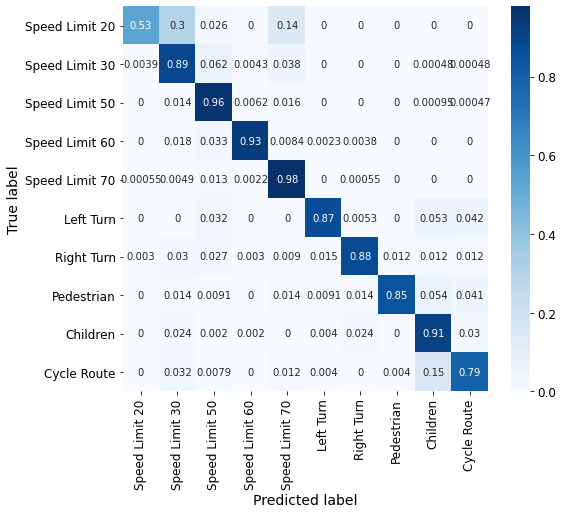

In [151]:
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred_class).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=5)
con_mat_df = pd.DataFrame(con_mat_norm,index = class_names, columns = class_names)
con_mat_df
figure = plt.figure(figsize=(8, 7))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### TP, TN, FP, FN

In [152]:
df_seq_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, y_pred_class))
df_seq_cm.columns=class_names
df_seq_cm.index = class_names
df_seq_cm

,Speed Limit 20,Speed Limit 30,Speed Limit 50,Speed Limit 60,Speed Limit 70,Left Turn,Right Turn,Pedestrian,Children,Cycle Route
Speed Limit 20,101,58,5,0,27,0,0,0,0,0
Speed Limit 30,8,1844,129,9,78,0,0,0,1,1
Speed Limit 50,0,30,2034,13,33,0,0,0,2,1
Speed Limit 60,0,24,44,1228,11,3,5,0,0,0
Speed Limit 70,1,9,24,4,1787,0,1,0,0,0
Left Turn,0,0,6,0,0,165,1,0,10,8
Right Turn,1,10,9,1,3,5,294,4,4,4
Pedestrian,0,3,2,0,3,2,3,187,12,9
Children,0,12,1,1,0,2,12,0,456,15
Cycle Route,0,8,2,0,3,1,0,1,38,199


<AxesSubplot:title={'center':'Confusion Matrix (TP, TN, FP, FN)'}>

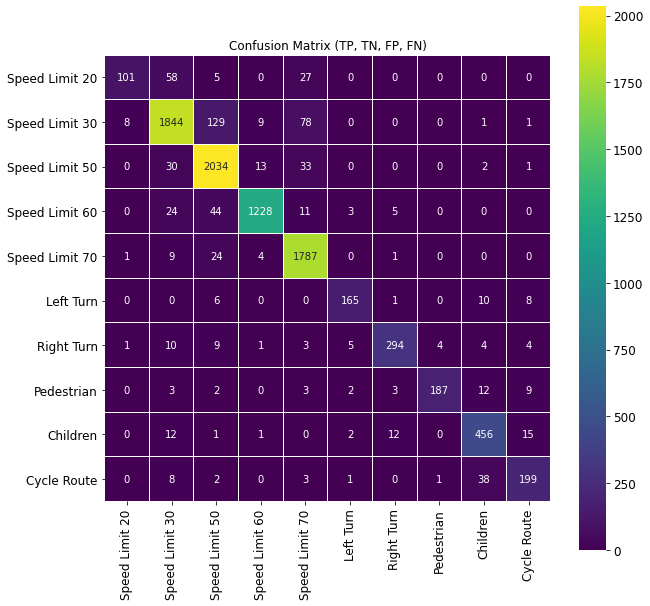

In [153]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Confusion Matrix (TP, TN, FP, FN)')
sns.heatmap(df_seq_cm, 
            cmap="viridis",
            fmt=".0f",
            annot_kws={"fontsize":10},
            square=True,
            annot=True,
           linewidths=.01,
           ax=ax)

### Grid Search

In [154]:
model = KerasClassifier(build_fn=f_CNNModelGridSearch, verbose=0)
optimizers = ['adam']
init = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(epochs=GS_EPOCHS, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=5, return_train_score=False, n_jobs=-1, cv=None)

In [155]:
grid_result = grid.fit(XX, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 106.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 356.5min finished


In [156]:
gr_results = grid_result.cv_results_

In [157]:
scores_df = pd.DataFrame(gr_results).sort_values(by=['param_epochs','param_init'])
scores_df = scores_df.drop(['params'], axis=1)
scores_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_epochs,param_init,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,34.404133,4.490980,5.009582,1.938708,1,glorot_normal,0.381837,0.648091,0.374613,0.087719,0.133643,0.325181,0.201494,32
5,39.969791,5.142041,9.198602,5.386840,1,glorot_uniform,0.185243,0.479360,0.393705,0.205366,0.141383,0.281011,0.131478,34
6,39.154672,3.115393,7.353760,2.768193,1,he_normal,0.488132,0.641383,0.446336,0.208978,0.130547,0.383075,0.187532,29
7,44.275836,4.883700,6.661520,3.025423,1,he_uniform,0.381321,0.436532,0.361197,0.387513,0.126419,0.338596,0.108940,31
1,37.003714,9.661263,3.738142,0.580310,1,lecun_uniform,0.619195,0.331785,0.372033,0.306502,0.127451,0.351393,0.157920,30
2,28.557799,2.692991,3.224582,0.348157,1,normal,0.305470,0.615583,0.268318,0.134159,0.102683,0.285243,0.182195,33
0,29.438416,0.589266,2.627387,0.188846,1,uniform,0.520640,0.447884,0.116099,0.090815,0.043344,0.243756,0.199091,35
3,30.220077,3.508371,4.403531,1.918808,1,zero,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36
12,223.497953,5.403952,9.936136,2.573780,5,glorot_normal,0.613519,0.881837,0.877709,0.672343,0.162023,0.641486,0.262751,26
13,221.412313,7.123334,10.802366,2.440651,5,glorot_uniform,0.795666,0.899897,0.898349,0.765738,0.160475,0.704025,0.277049,8


In [158]:
print('Optimal Combination',grid_result.best_params_)

Optimal Combination {'epochs': 20, 'init': 'he_uniform'}
